# Time-series Prediction

A time series is a sequence of observations, ordered in time. Forecasting involves training a model on historical data and using them to predict future observations. A simple example is a linear auto-regressive model. The linear auto-regressive (AR) model of a time-series $Z_t$ with $t=1,2,\dots,\infty$ is given by

$$\hat{z}_t = a_1 z_{t-1} + a_2 z_{t-2} + \cdots + a_p z_{t-p},$$

with $a_i \in \mathbb{R}$ for $i=1, \dots, p$ and $p$ the model lag. The prediction for a certain time $t$ is equal to a weighted sum of the previous values up to a certain lag $p$. In a similar way, the nonlinear (NAR) variant is described as

$$\hat{z}_t = f(z_{t-1}, z_{t-2}, \dots, z_{t-p}).$$

The figure below visualizes this process.

<img src="https://raw.githubusercontent.com/KULasagna/ANN_DL_public/master/assets/nar.jpg" width="600">

Remark that in this way, the time-series identification can be written as a classical black-box regression modeling problem $\hat{y}_t=f(x_t)$ with $y_t=z_t$ and $x_t=[z_{t-1}, z_{t-2}, \dots, z_{t-p}]$. When preparing the dataset and applying train/validation/test splits, it is important to prevent *data leakage* by respecting the temporal information flow. More precisely, a datapoint $z_t$ should not be part of two splits &mdash; either as input $x_t$ or target $y_t$ &mdash; and training (or validation) sets should not contain datapoints that occur after test datapoints.

In this notebook, we work on the time-series prediction problem using a multilayer perceptron (MLP) and a long short-term memory network (LSTM).

## Colab Setup
This part is only required when running this notebook "in the cloud" on [Google Colab](https://colab.research.google.com). When running it locally, skip this part and go to the next section.

In [ ]:
# Load some auxiliary files from github.
!wget https://raw.githubusercontent.com/KULasagna/ANN_DL_public/master/session2/SantaFe.npz

--2024-03-24 10:50:13--  https://raw.githubusercontent.com/KULasagna/ANN_DL_public/master/session2/SantaFe.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1598 (1.6K) [application/octet-stream]
Saving to: ‘SantaFe.npz’

SantaFe.npz         100%[===================>]   1.56K  --.-KB/s    in 0s      

2024-03-24 10:50:13 (22.7 MB/s) - ‘SantaFe.npz’ saved [1598/1598]



## Setup
Import all the necessary modules used throughout this notebook and define some helper methods to work with timeseries data and visualize the results.

In [ ]:
# Import the required modules for this notebook
from dataclasses import dataclass
import keras
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.model_selection import TimeSeriesSplit

This code snippet provides functionality for preparing and manipulating time series data for machine learning tasks. Let's break down its components:

### `@dataclass` and `Fold` Class
The `@dataclass` decorator is used to automatically generate special methods for the class `Fold`, including `__init__`, `__repr__`, `__eq__`, and `__hash__`, based on the class attributes. The `Fold` class has two attributes, `train_idxs` and `val_idxs`, which are NumPy arrays representing indices for training and validation data points, respectively.

### `prepare_timeseries` Function
This function prepares time series data for training (and optionally validation) by creating input sequences (`data`) and their corresponding targets (`targets`) using the concept of lag. A "lag" here refers to the number of time steps used to predict the next value in the series.

- It uses the `scipy.linalg.hankel` function to create a Hankel matrix from the time series data, which helps in forming the sequences of lagged observations.
- If validation is needed, it employs the `TimeSeriesSplit` from Scikit-learn to generate training and validation sets. This method splits the time series data into folds for cross-validation, ensuring that the validation set comes after the training set in time.
- It returns the input sequences (`data`), their corresponding targets (`targets`), and, if validation is specified, a list of `Fold` objects representing the indices of training and validation data in each fold.

### `shift` Function
This function shifts a window of values by appending new values at the end and dropping the oldest values, effectively updating the window with new observations. It's useful for maintaining a moving window of data in time series forecasting.

### `normalize` Function
This function applies z-score normalization to a time series, transforming the data to have a mean of 0 and a standard deviation of 1. It optionally takes precomputed mean (`mu`) and standard deviation (`sigma`) as `params`. If `params` are not provided, it computes them from the provided time series. It returns the normalized time series along with the normalization parameters.

### `rescale` Function
This function reverses the normalization process, rescaling a normalized time series back to its original scale using the mean (`mu`) and standard deviation (`sigma`) parameters. It's useful for converting predictions made on normalized data back to their original scale for interpretation or comparison with original data values.

Overall, these functions collectively offer a set of tools for preparing time series data, managing sliding windows of observations, and applying normalization for machine learning tasks.

A Hankel matrix is a special type of square matrix that has constant skew diagonals (i.e., elements on a line from top-right to bottom-left are the same). It is a structured matrix often encountered in various areas of numerical analysis, control theory, and signal processing. The defining feature of a Hankel matrix is that each ascending skew-diagonal from left to right is constant. This means that for a Hankel matrix \(H\), the element at row \(i\) and column \(j\) satisfies \(H_{i,j} = H_{i-1, j+1}\).

Mathematically, a Hankel matrix for a given sequence \(a = [a_0, a_1, \ldots, a_{n-1}]\) can be represented as:
\[
\begin{pmatrix}
a_0 & a_1 & a_2 & \cdots & a_{n-1} \\
a_1 & a_2 & a_3 & \cdots & a_n \\
a_2 & a_3 & a_4 & \cdots & a_{n+1} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
a_{m-1} & a_m & a_{m+1} & \cdots & a_{m+n-2}
\end{pmatrix}
\]

In the context of time series analysis and the code provided, a Hankel matrix is used to transform a time series into a format suitable for machine learning models. Specifically, it rearranges a time series into a form where each row contains a sequence of lagged observations (a sliding window of the series), which can be used as input features for predicting future values of the series. This is accomplished by utilizing the `scipy.linalg.hankel` function, which constructs a Hankel matrix where the first column is the beginning of the time series and the last row is the end of the time series, effectively creating overlapping windows of the time series data that are used for training predictive models.

In [ ]:
@dataclass
class Fold:
  train_idxs: np.ndarray
  val_idxs: np.ndarray

def prepare_timeseries(timeseries, lag, validation_size=0, validation_folds=0):
  # Generate train (and validation) sets for the given timeseries and lag
  data = scipy.linalg.hankel(timeseries[:-lag], timeseries[-lag-1:-1])
  targets = timeseries[lag:]
  if validation_size > 0 and validation_folds > 0:
    tss = TimeSeriesSplit(test_size=validation_size, gap=lag)
    tss.n_splits = validation_folds
    folds = [Fold(train_idxs, val_idxs) for (train_idxs, val_idxs) in tss.split(data)]
    return data, targets, folds
  return data, targets

def shift(window, values):
  # Append new values to the given window (dropping the oldest values)
  result = np.empty(window.shape)
  values = np.atleast_1d(values)
  s = values.shape[0]
  result[:-s] = window[s:]
  result[-s:] = values
  return result

def normalize(timeseries, params=None):
  # Apply z-score normalization to the given timeseries
  if params is None:
    params = (np.mean(timeseries), np.std(timeseries))
  mu, sigma = params
  normalized = (timeseries - mu) / sigma
  return normalized, params

def rescale(timeseries, params):
  # Rescale the normalized timeseries back to its original values
  mu, sigma = params
  rescaled = mu + timeseries * sigma
  return rescaled

In [ ]:
def plot_history(history, title, filename=None):
  # Plot the train and validation loss curves
  fig, ax = plt.subplots(figsize=(10, 3))
  ax.semilogy(history.history['loss'], label='Train')
  if 'val_loss' in history.history:
    ax.semilogy(history.history['val_loss'], label='Validation')
  ax.legend()
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  plt.title(title)
  if filename is not None:
    plt.savefig(f"{filename}.svg")
  plt.show()

def plot_timeseries(timeseries_dict, title, filename=None):
  # Plot the given timeseries
  fig, ax = plt.subplots(figsize=(10, 3))
  for label, (start, ts) in timeseries_dict.items():
    ax.plot(start + np.arange(len(ts)), ts, label=label)
  ax.legend()
  ax.set_xlabel('Timestep')
  ax.set_ylabel('Laser intensity')
  plt.title(title)
  if filename is not None:
    plt.savefig(f"{filename}.svg")
  plt.show()

## Santa Fe Laser Dataset
The Santa Fe laser dataset is obtained from a chaotic laser which can be described as a nonlinear dynamical system. The first $1000$ data points can be used for training and validation purposes. The aim is to predict the next $100$ points (it is forbidden to include these points in the training or validation sets!). Both datasets are stored in the `SantaFe.npz` file and are visualized below.

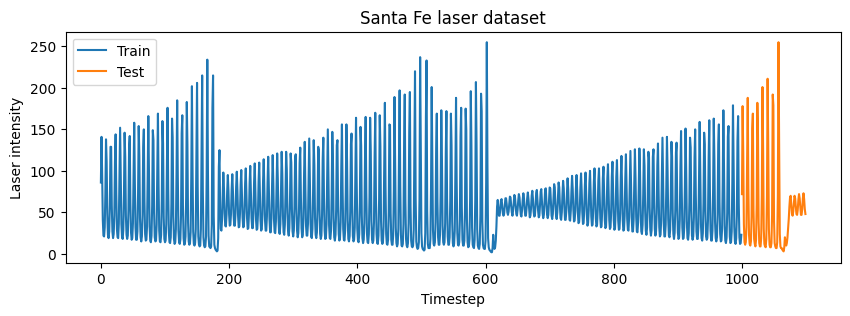

In [ ]:
santafe = np.load('SantaFe.npz')
train_series = santafe['A']
test_series = santafe['Acont']
plot_timeseries({
    'Train': (0, train_series),
    'Test': (len(train_series), test_series)
}, 'Santa Fe laser dataset')

To train the various nonlinear autoregressive models, it will be useful to prepare the timeseries dataset beforehand. We start by normalizing the train and test sets.

In [ ]:
normalized, params = normalize(santafe['A'])
normalized_test, _ = normalize(santafe['Acont'], params)

Next, the `prepare_timeseries` function is used to convert the timeseries into training data ($x_t$) and targets ($y_t$). Make sure you understand what the function does by trying it out on a small toy example.

In [ ]:
timeseries = np.arange(100)  # Increase this number to create a larger time series
lag = 10  # Try different values for the lag
validation_size = int(0.3*len(timeseries)) # 70/30 trainning/validation rati
validation_folds = int(len(timeseries)/(validation_size + lag))
data, targets, folds = prepare_timeseries(timeseries, lag, validation_size=validation_size, validation_folds=validation_folds)  # Examine the effect of the validation size and number of validation folds
print(f"Original timeseries: {timeseries}")
print(f"Data for lag {lag}: {data}")
print(f"Targets: {targets}")
for i, fold in enumerate(folds):
  print(f"Fold {i}:")
  print(f"  Train:     data={data[fold.train_idxs]}, targets={targets[fold.train_idxs]}")
  print(f"  Validate:  data={data[fold.val_idxs]}, targets={targets[fold.val_idxs]}")

Original timeseries: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Data for lag 10: [[ 0  1  2  3  4  5  6  7  8  9]
 [ 1  2  3  4  5  6  7  8  9 10]
 [ 2  3  4  5  6  7  8  9 10 11]
 [ 3  4  5  6  7  8  9 10 11 12]
 [ 4  5  6  7  8  9 10 11 12 13]
 [ 5  6  7  8  9 10 11 12 13 14]
 [ 6  7  8  9 10 11 12 13 14 15]
 [ 7  8  9 10 11 12 13 14 15 16]
 [ 8  9 10 11 12 13 14 15 16 17]
 [ 9 10 11 12 13 14 15 16 17 18]
 [10 11 12 13 14 15 16 17 18 19]
 [11 12 13 14 15 16 17 18 19 20]
 [12 13 14 15 16 17 18 19 20 21]
 [13 14 15 16 17 18 19 20 21 22]
 [14 15 16 17 18 19 20 21 22 23]
 [15 16 17 18 19 20 21 22 23 24]
 [16 17 18 19 20 21 22 23 24 25]
 [17 18 19 20 21 22 23 24 25 26]
 [18 19 20 21 22 23 24 25 26 27]
 [19 20 21 22 23 24 25 26 27 

When setting the validation size and the number of validation folds in the context of the `prepare_timeseries` function you've described, you're essentially configuring how to split your time series data into training and validation sets for the purpose of cross-validation. These parameters directly influence the robustness of your model evaluation and the reliability of performance metrics. Let's understand their impact and how to choose them:

### Validation Size
- The `validation_size` parameter specifies the size of the validation set. This is often defined as a fraction of the total dataset size. For instance, a `validation_size` of 0.2 means that 20% of the data at the end of the time series will be used for validation, while the remaining 80% will be available for training.
- Choosing a validation size is a balance between having enough data to train your model effectively and having enough data to validate the model's performance reliably. A common split ratio for time series data is 80/20 or 70/30 (training/validation).

### Validation Folds
- The `validation_folds` parameter specifies the number of folds or splits to use in the validation process. This is relevant for cross-validation, where the model is trained and validated several times, each time with a different fold acting as the validation set and the remaining data used for training.
- More folds mean more training/validation cycles, which can provide a more accurate estimate of model performance but at the cost of increased computational time and complexity. For time series, the number of folds is often limited by the chronological nature of the data; you cannot randomly shuffle time series data as you might with cross-sectional data without disrupting temporal dependencies.
- A typical choice might be 5 or 10 folds for cross-validation, but the best choice depends on the size of your dataset and the computational resources at your disposal.

### Relationship Between Parameters and Data Size
- The total size of your input data constrains the choices for `validation_size` and `validation_folds`. Specifically, you need enough data points to create meaningful splits. For instance, if you have a very small dataset, using a large number of folds or a very small validation size might not be practical because each individual fold might not contain enough data to be representative or to train the model effectively.
- It's also essential to consider the "gap" parameter used in time series splitting, corresponding to the lag in your data. The gap ensures that there's a temporal buffer between your training and validation sets, which can affect how you set your validation size and folds.

### Recommendations
- Start with standard practices, such as a validation size of 20-30% and 5-10 folds, and adjust based on the performance and specific characteristics of your time series data (e.g., seasonality, length).
- Ensure your validation set is large enough to capture the key patterns in the data and that each fold in cross-validation has a meaningful amount of data.
- Remember, the objective is to validate the model's ability to generalize to unseen data effectively, so the settings should reflect the balance between a robust training process and an accurate estimation of performance on new data.

Once you understand the dataset structure, apply it to the normalized Santa Fe timeseries. You can come back to these cells later to change the values of the lag or validation parameters.

In [ ]:
print("normalized size: ", len(normalized))
validate_= int(0.2*(len(normalized)))
print("validate size: ", validate_)
# @title Parameters { run: "auto" }
lag = 15 # @param {type:"slider", min:1, max:100, step:1}
folds_ = int(len(normalized)/(validate_+lag))
print("folds: ", folds_)
validation_size = 200 # @param {type:"slider", min:10, max:200, step:1}
validation_folds = 4 # @param {type:"slider", min:1, max:10, step:1}
# This is the hidden dimension of the MLP and LSTM networks trained later in this notebook
H = 25 # @param {type:"slider", min:10, max:100, step:1}

normalized size:  1000
validate size:  200
folds:  4


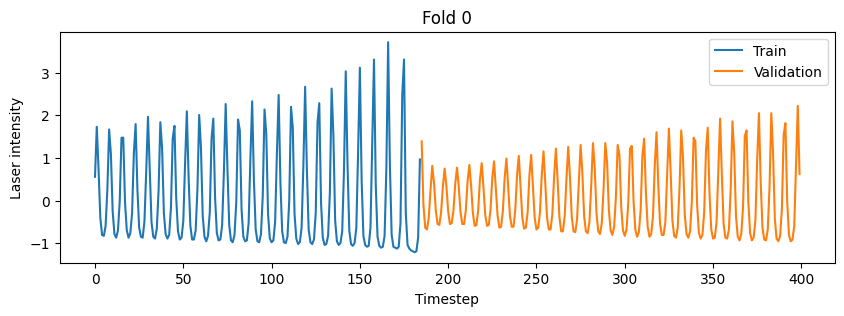

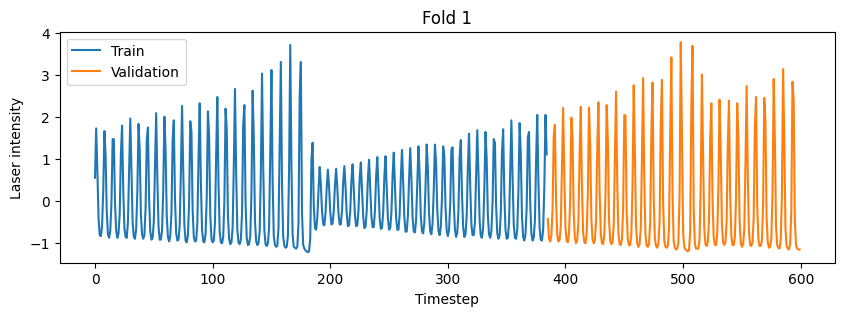

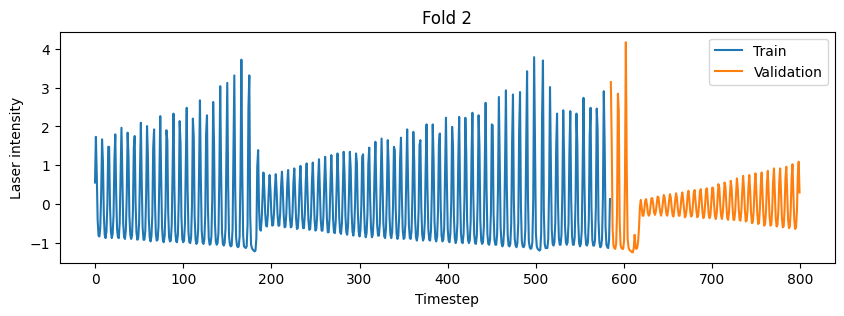

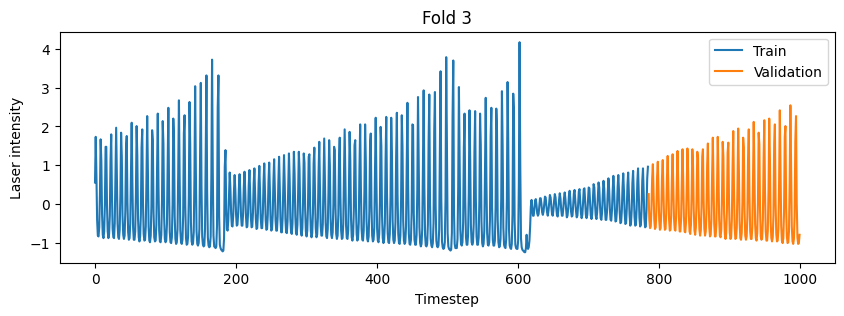

In [ ]:
data, targets, folds = prepare_timeseries(normalized, lag, validation_size, validation_folds)
# Plot train and validation data for each fold:
for f, fold in enumerate(folds):
  train_series = np.concatenate([data[fold.train_idxs[0]], targets[fold.train_idxs]])
  val_series = np.concatenate([data[fold.val_idxs[0]], targets[fold.val_idxs]])
  plot_timeseries({"Train": (0, train_series), "Validation": (len(train_series), val_series)}, f"Fold {f}")

## MLP
We now train a first nonlinear autoregressive (NAR) model on the training set and choose the hyperparameters based on the predictive performance on the validation sets. This first model is a multilayer perceptron (MLP) and training is done in feedforward mode using the prepared training set

$$\hat{z}_t = w^\top \tanh(V[z_{t-1}; z_{t-2}; \dots; z_{t-p}] + \beta).$$

In order to make predictions, the trained network is used in an iterative way as a recurrent network

$$\hat{z}_t = w^\top \tanh(V[\hat{z}_{t-1}; \hat{z}_{t-2}; \dots; \hat{z}_{t-p}] + \beta).$$

In [ ]:
# Define the MLP network architecture
def MLP(input_dim, hidden_dim, output_dim, activation='tanh'):
  return keras.Sequential([
    keras.layers.Input(shape=[input_dim]),  # Expect input of shape (B, I) with B batch size, I input size
    keras.layers.Dense(units=hidden_dim, activation=activation),  # Output of shape (B, H) with H hidden feature size
    keras.layers.Dense(units=output_dim)  # Output of shape (B, O) with O output size
  ])

Train the MLP on the last training fold. You can later put this code in a `for` loop to train on each of the training folds for determining the optimal hyperparameters using $N$-fold cross-validation.

In [ ]:
net = MLP(lag, H, 1)
net.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=0.01)
)
fold = folds[-1]
history = net.fit(data[fold.train_idxs], targets[fold.train_idxs],
                  validation_data=(data[fold.val_idxs], targets[fold.val_idxs]),
                  epochs=200, verbose=0)

Plot the train and validation loss curves.

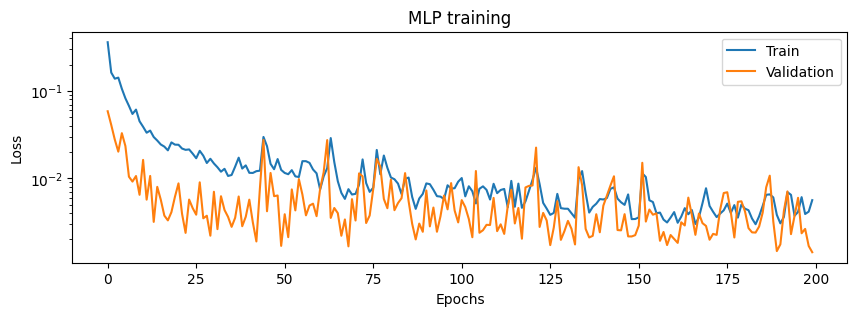

In [ ]:
plot_history(history, "MLP training")

The MSE on the test set is: 4071.205


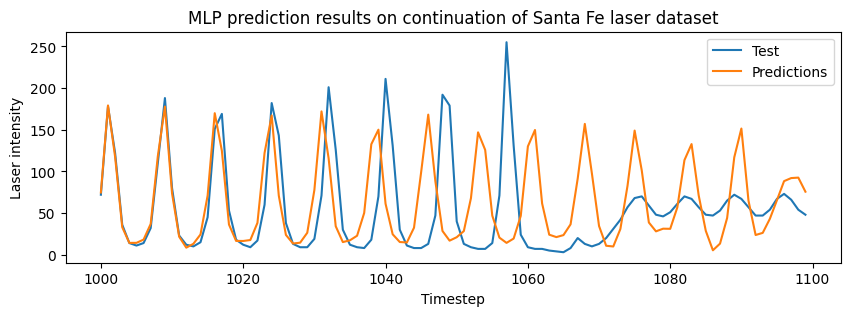

In [ ]:
# Evaluation on test set
test_data = shift(data[-1], targets[-1])
predictions = np.empty(normalized_test.shape)
for t in range(len(predictions)):
  predictions[t] = net.predict(test_data.reshape((1, lag)), verbose=0).squeeze()
  test_data = shift(test_data, predictions[t])

# Rescale predictions
predictions_mlp = rescale(predictions, params)

# Compute the mean squared error between the predictions and test set
mse = np.mean((test_series - predictions_mlp)**2)
print("The MSE on the test set is: {:.3f}".format(mse))

# Plot
plot_timeseries({"Test": (1000, test_series), "Predictions": (1000, predictions_mlp)}, "MLP prediction results on continuation of Santa Fe laser dataset")

To train the MLP on each of the training folds for determining the optimal hyperparameters using \(N\)-fold cross-validation, you need to modify your existing code to loop over each fold instead of just using the last fold.

This loop iterates through all the folds and trains the model on each fold's training set, validating against each fold's validation set. Note that I've added a line to reinitialize the model's weights for each fold with `net.set_weights()`. This is crucial to ensure that each fold starts training with a fresh model, preventing information leakage between folds.

Remember to replace `np.random.normal(size=w.shape)` with the appropriate method of weight initialization for your network. This is a placeholder to indicate that you should reinitialize weights; the actual method will depend on your model architecture and choice of weight initialization scheme.

Finally, I've added a print statement to help keep track of progress through the folds, and I'm collecting the history of each fold's training in a list called `histories`. This will allow you to analyze the performance across folds after the cross-validation loop completes.

To investigate model performance with different lags and numbers of neurons (hidden units in the MLP), you can follow these steps:

### Step 1: Define a range of lags and neurons to test
Decide on a set of lags (e.g., 1, 5, 10, 20) and the number of neurons (e.g., 5, 10, 25, 50) to test. These ranges should be based on the nature of the time series data and computational resources available.

### Step 2: Grid Search
Perform a grid search where you train and evaluate a separate model for each combination of lag and neuron count. Keep in mind that for each combination, you should retrain your model using cross-validation to find the mean squared error on the validation set.

### Step 3: Training Loop
Within the grid search, use the training loop described previously to train the MLP for each fold in the cross-validation set. Keep track of the validation MSE for each fold.

### Step 4: Evaluation on the Test Set
For each combination of parameters that you test, use the best-performing model (based on validation MSE) to make predictions on the test set. Use the provided code snippet to predict test set values and calculate the test MSE.

### Step 5: Record Keeping
Record the MSE for each parameter combination. You should have a systematic way to store these values, perhaps in a table or a structured dictionary, along with the corresponding lag and neuron count.

### Step 6: Analysis
Analyze the results to determine which combination of lag and neuron count yields the lowest MSE on the test set. This combination is your best-performing model.

### Step 7: Discuss and Conclude
Discuss the influence of each parameter on model performance. Typically, more neurons can capture more complex patterns, but also run the risk of overfitting. Similarly, a larger lag might provide more historical context for predictions, but could also introduce noise or irrelevant information. The best combination will balance these aspects effectively.

You will need to define `perform_cross_validation` and `evaluate_on_test_set` functions to perform the cross-validation training and test evaluation, respectively.

The grid search will likely be computationally intensive, so you may want to start with a small set of parameters and expand as needed based on initial results. Keep in mind to also visualize the learning curves to ensure that the model isn't overfitting or underfitting for a particular set of hyperparameters.

Testing lag=1, H=5
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE for lag=1, H=5: 0.624


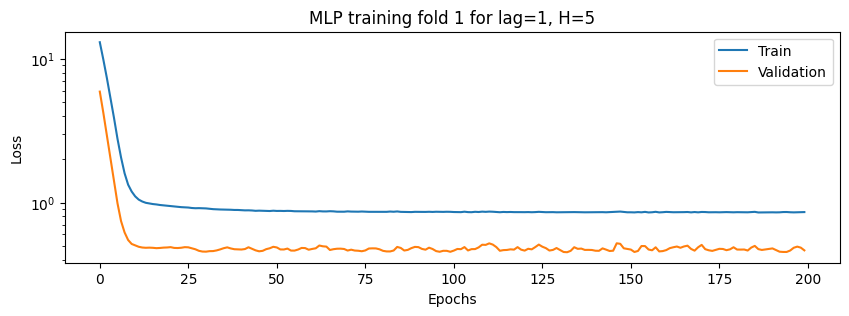

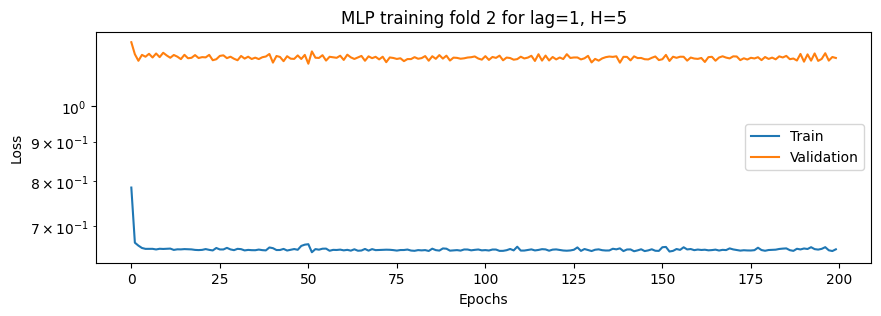

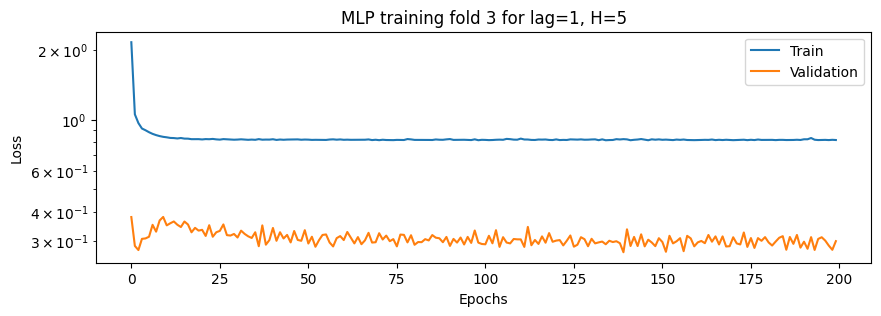

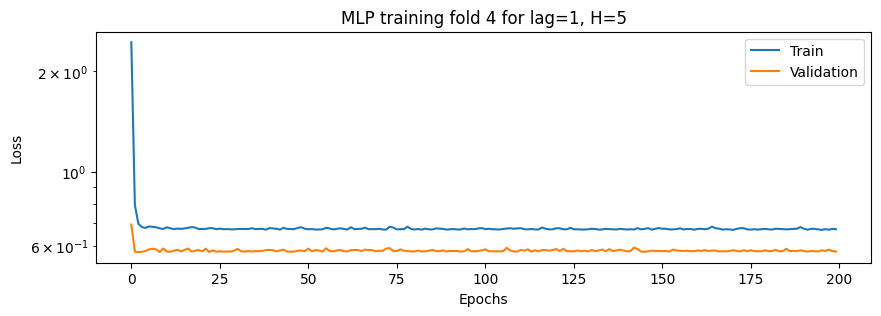

Testing lag=1, H=10
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE for lag=1, H=10: 0.643


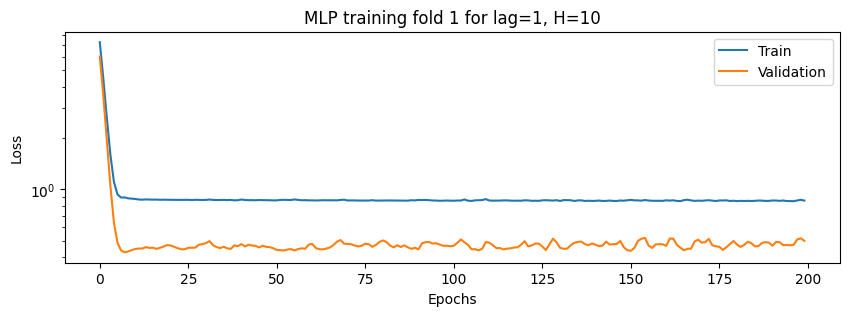

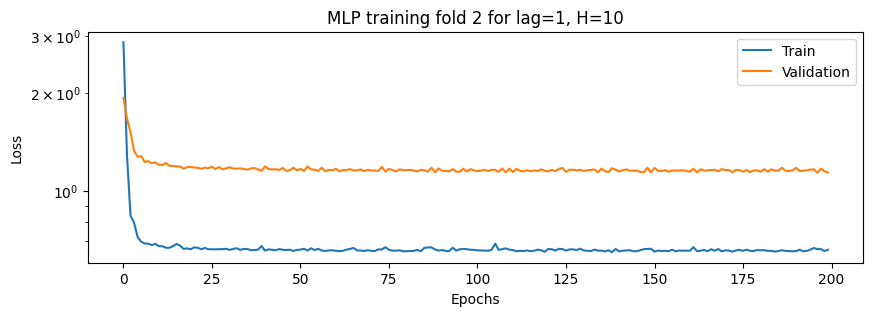

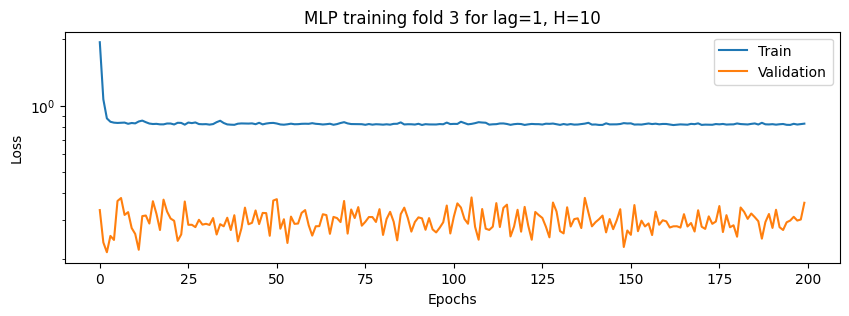

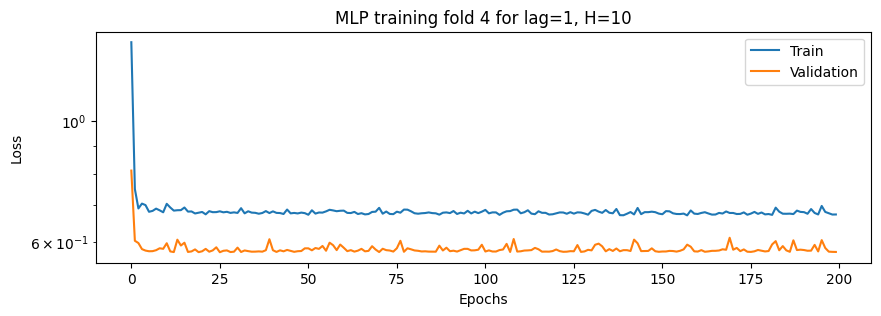

Testing lag=1, H=25
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE for lag=1, H=25: 0.652


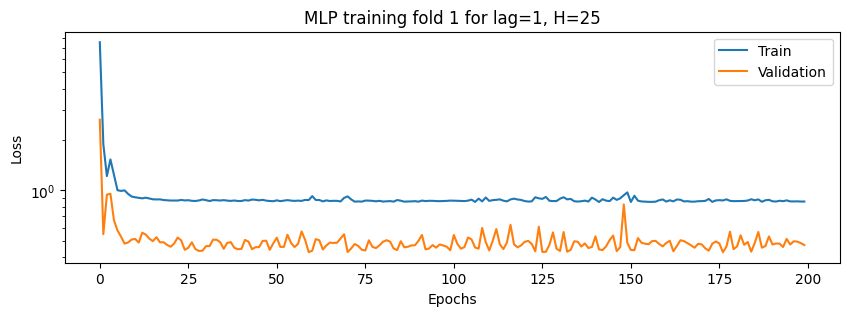

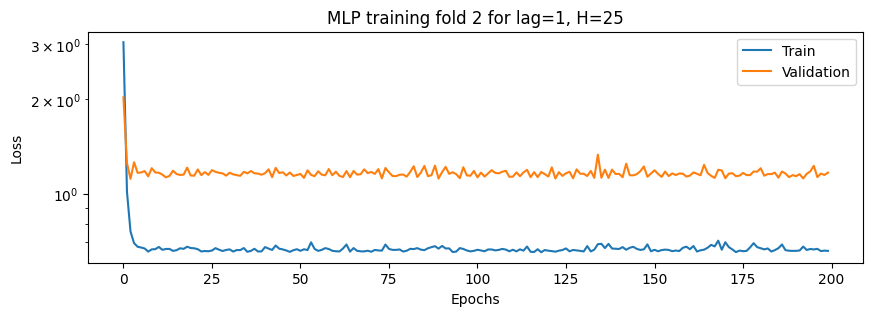

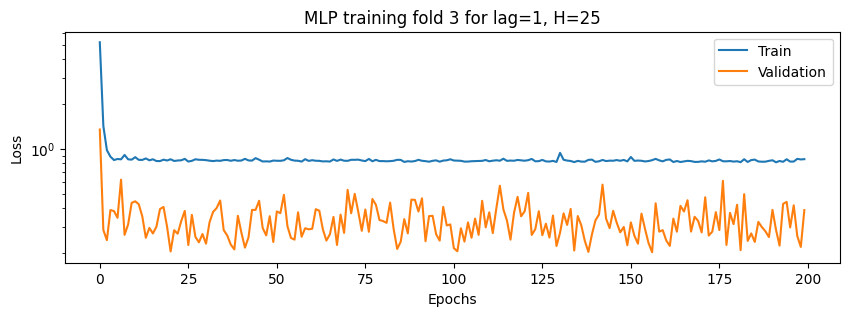

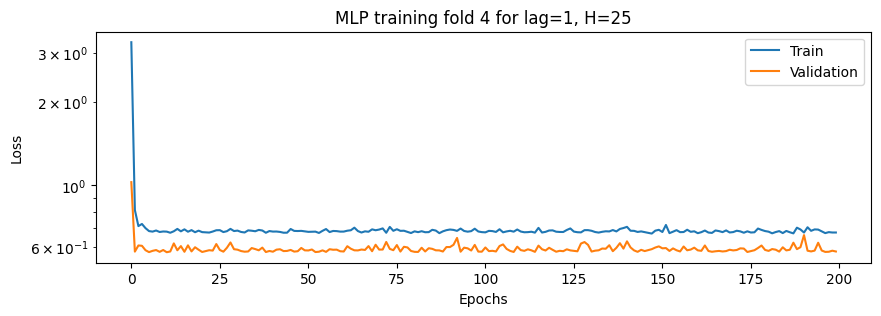

Testing lag=1, H=50
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE for lag=1, H=50: 0.667


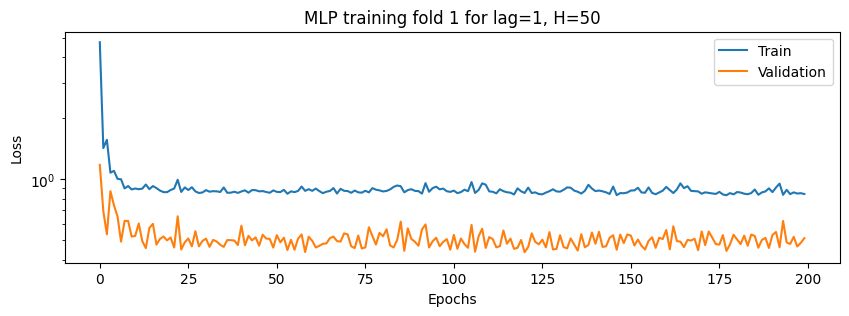

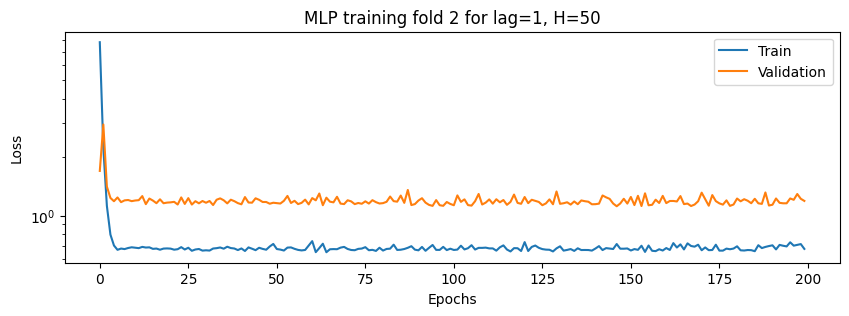

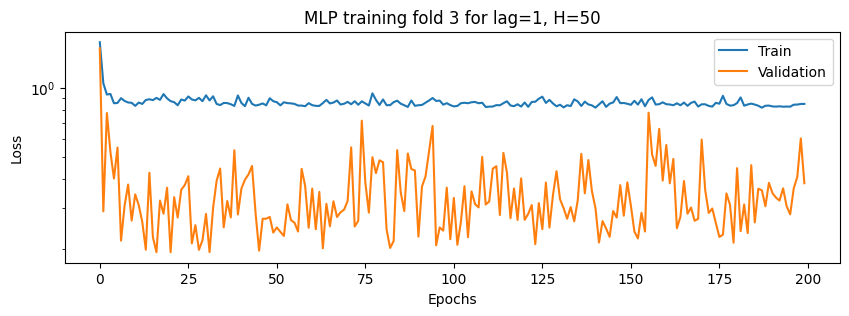

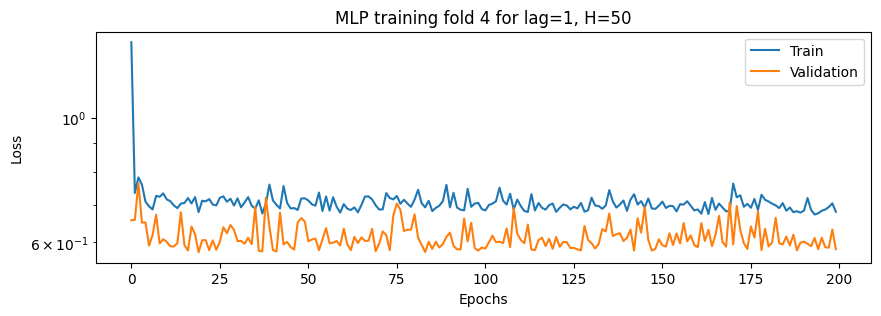

Testing lag=5, H=5
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE for lag=5, H=5: 0.048


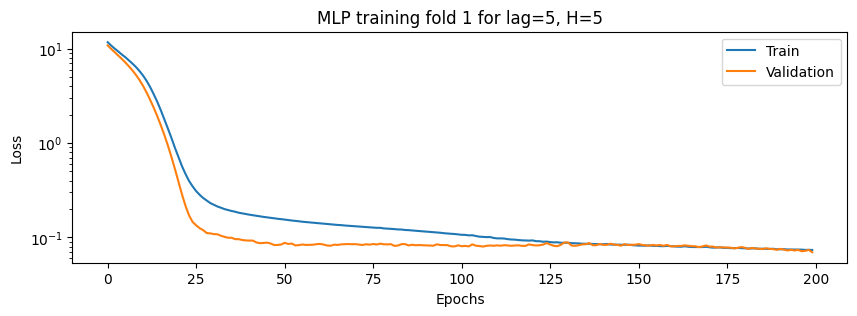

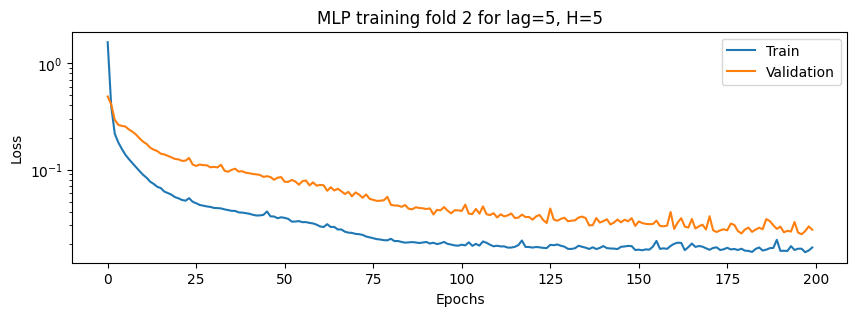

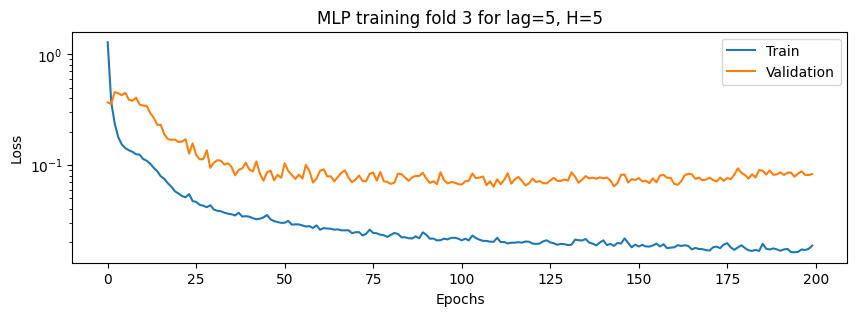

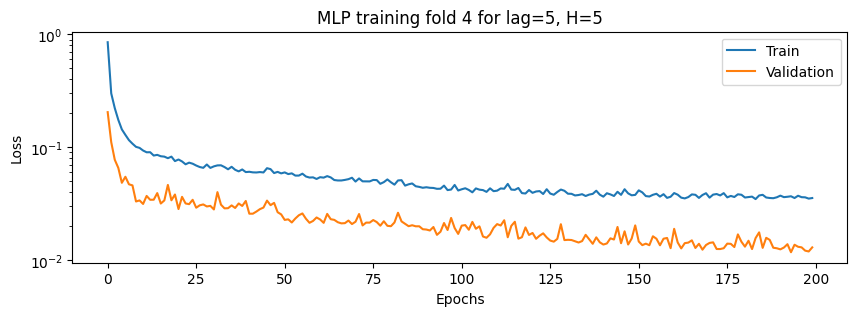

Testing lag=5, H=10
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE for lag=5, H=10: 0.042


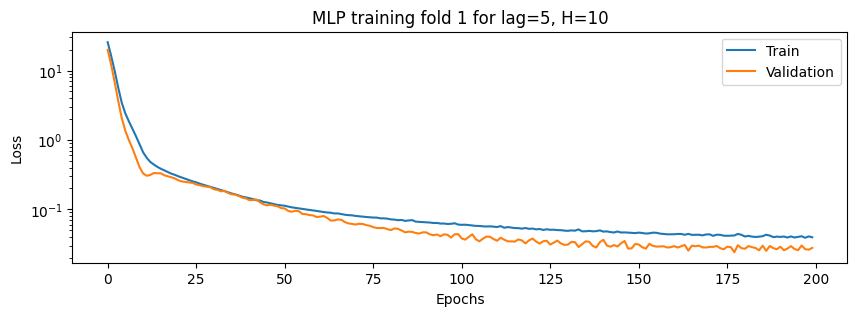

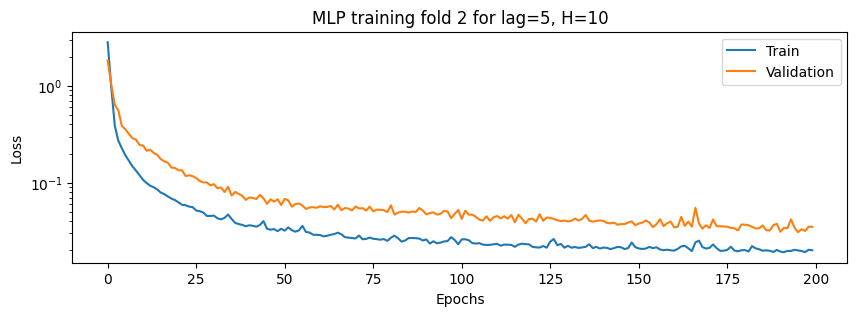

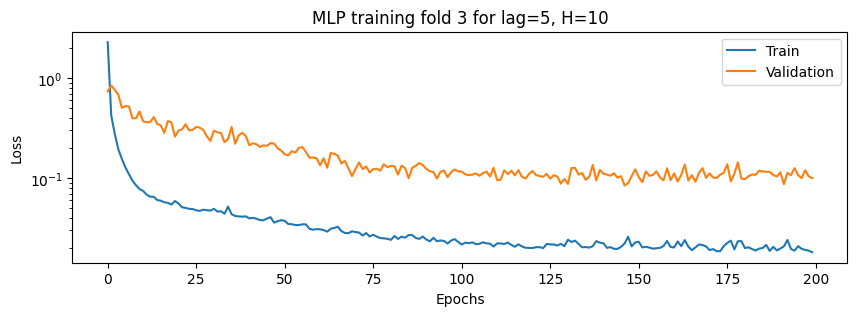

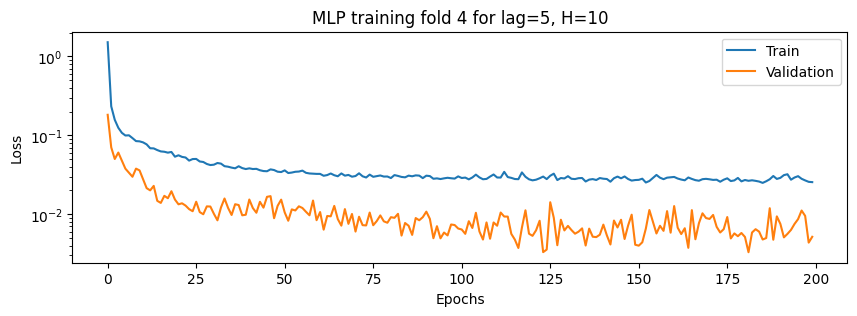

Testing lag=5, H=25
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE for lag=5, H=25: 0.054


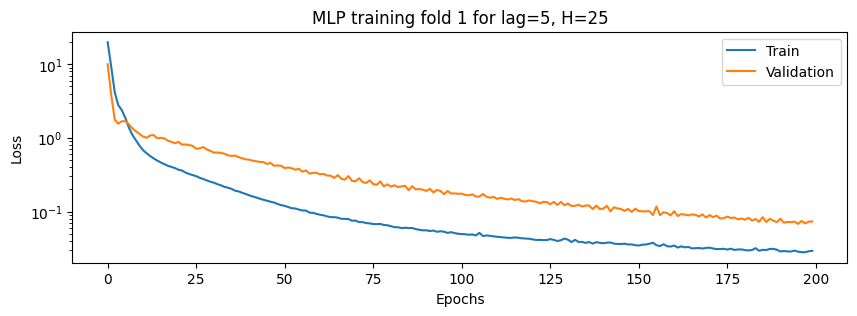

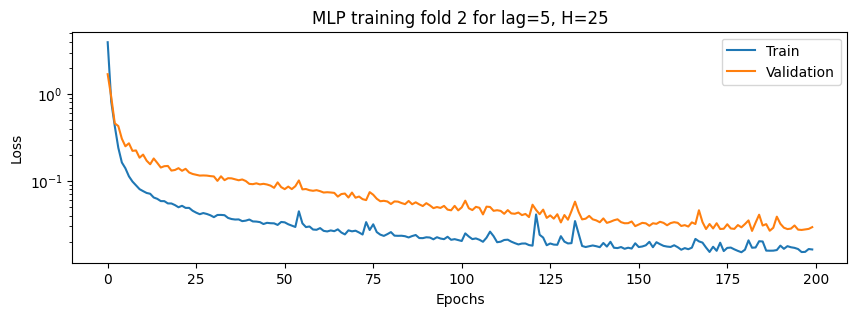

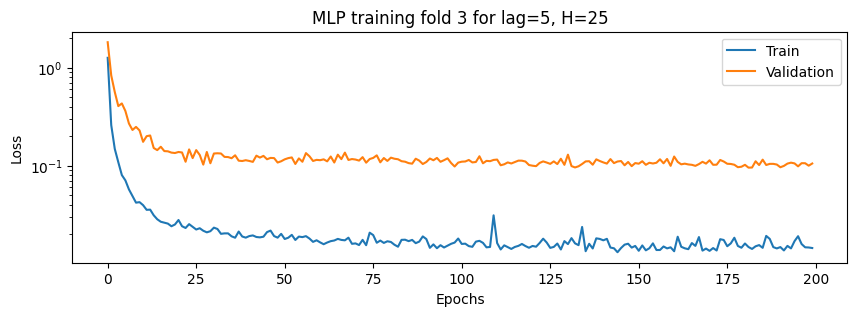

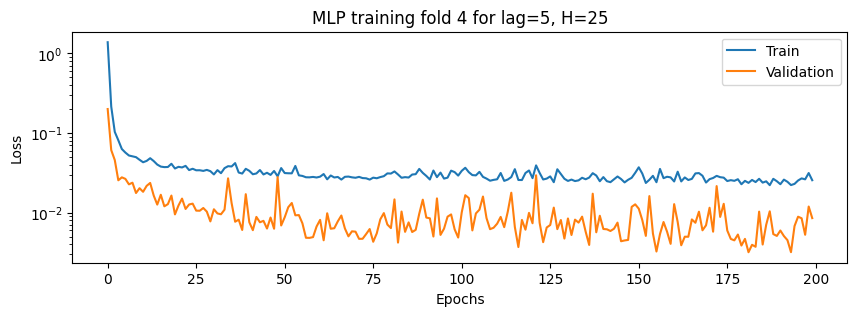

Testing lag=5, H=50
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE for lag=5, H=50: 0.069


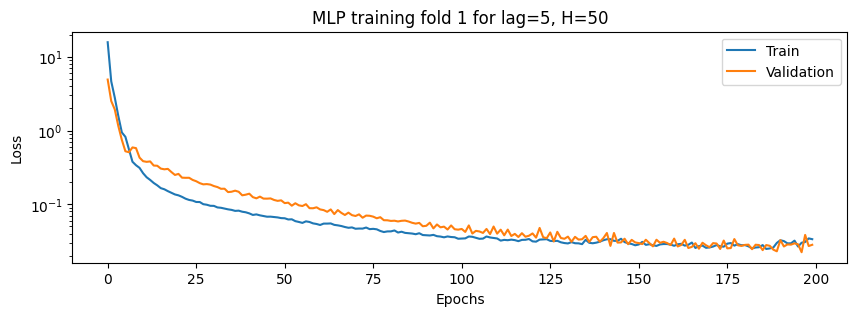

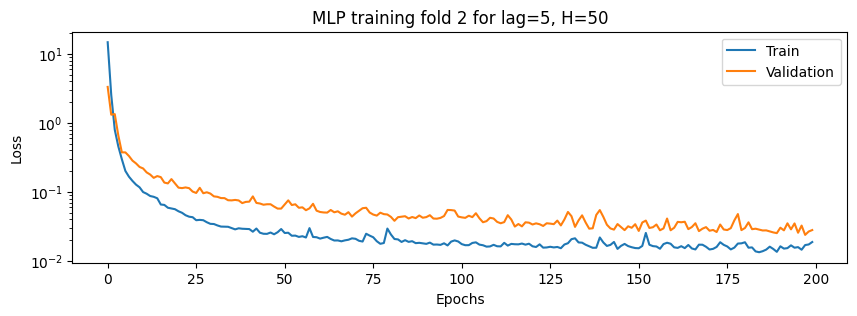

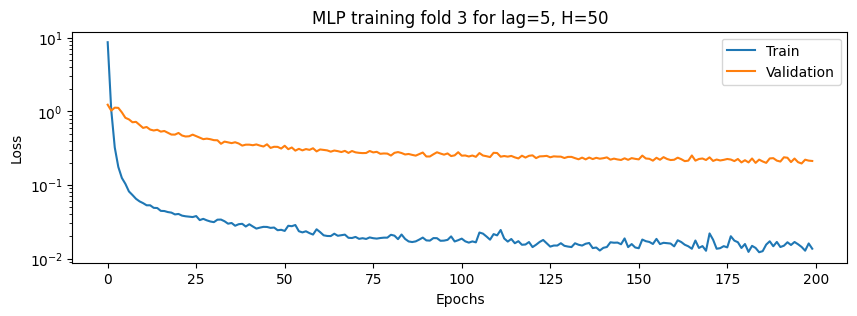

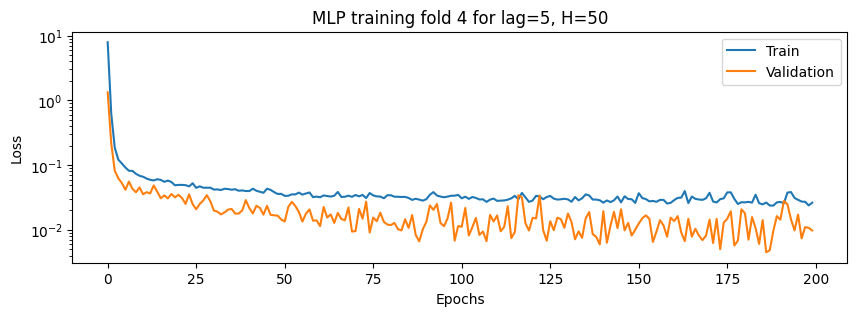

Testing lag=10, H=5
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE for lag=10, H=5: 0.190


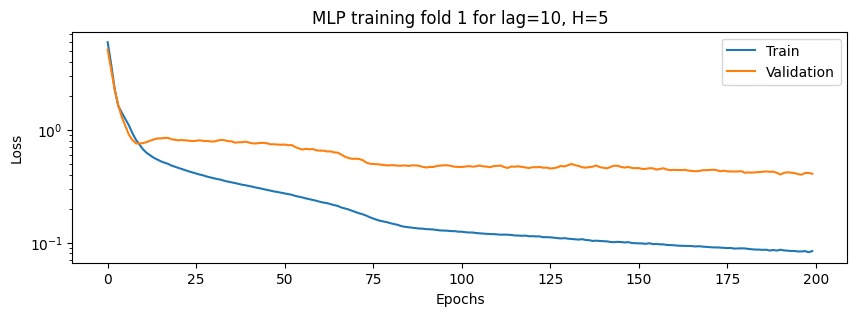

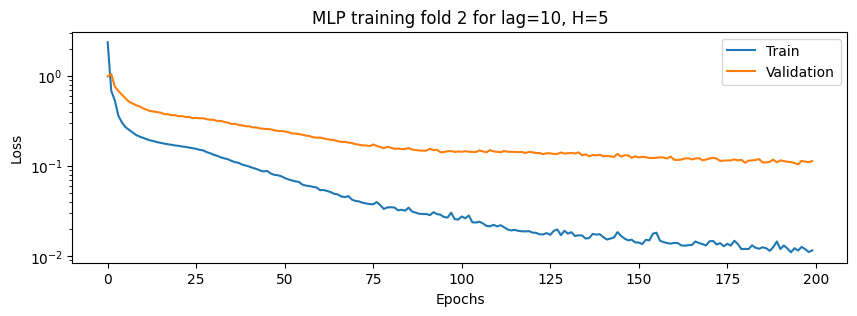

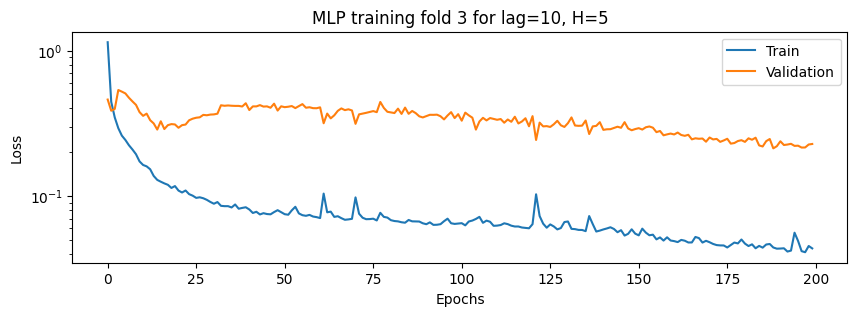

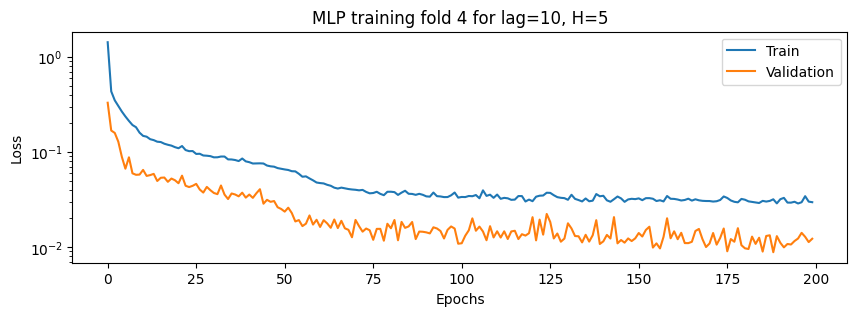

Testing lag=10, H=10
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE for lag=10, H=10: 0.110


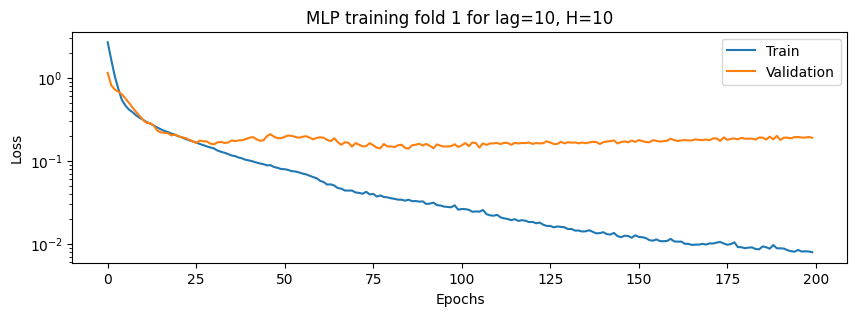

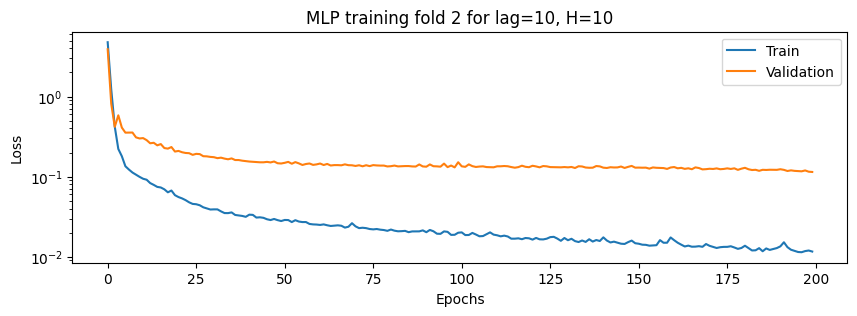

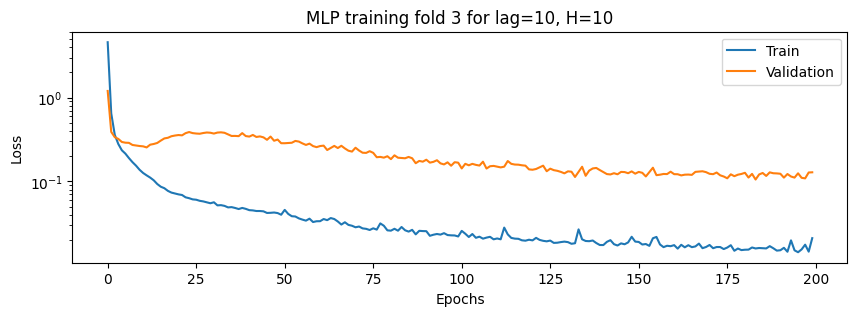

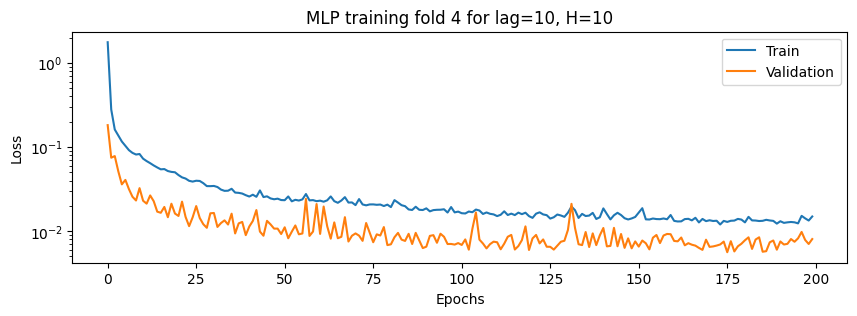

Testing lag=10, H=25
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE for lag=10, H=25: 0.179


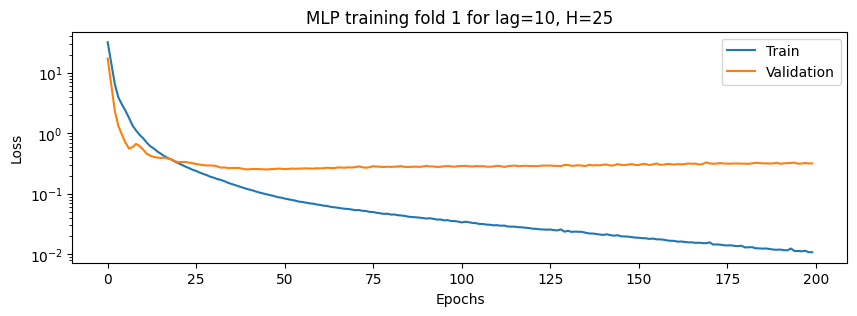

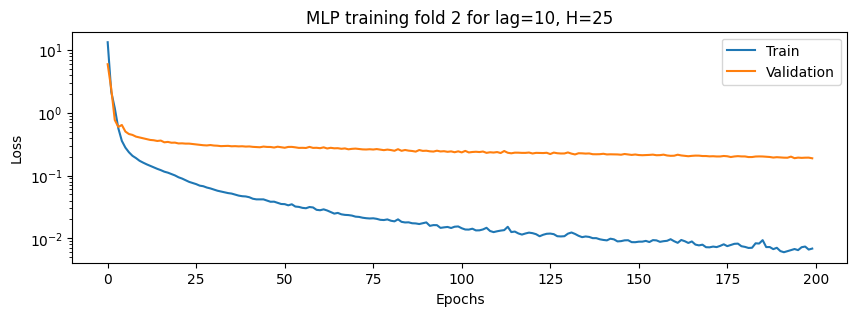

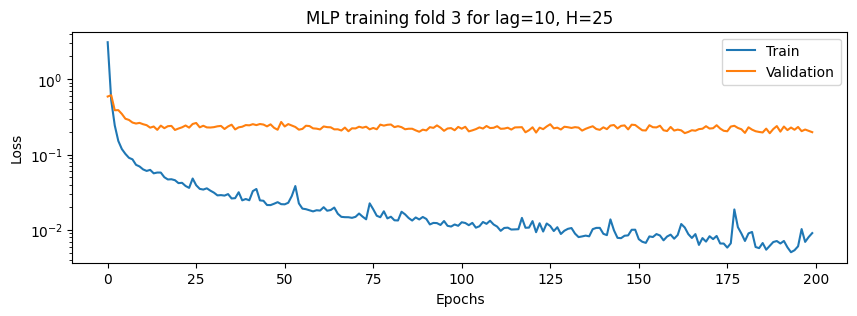

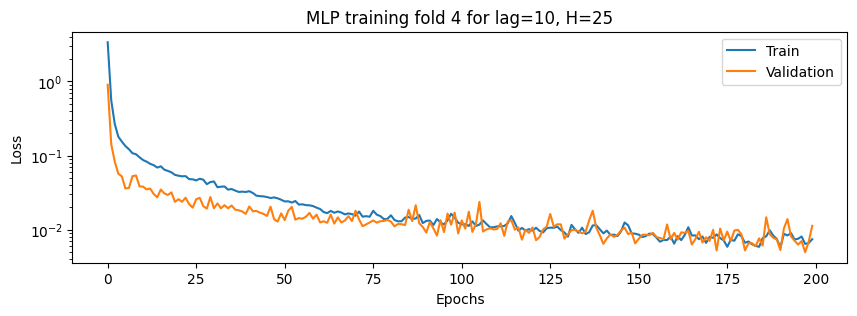

Testing lag=10, H=50
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE for lag=10, H=50: 0.310


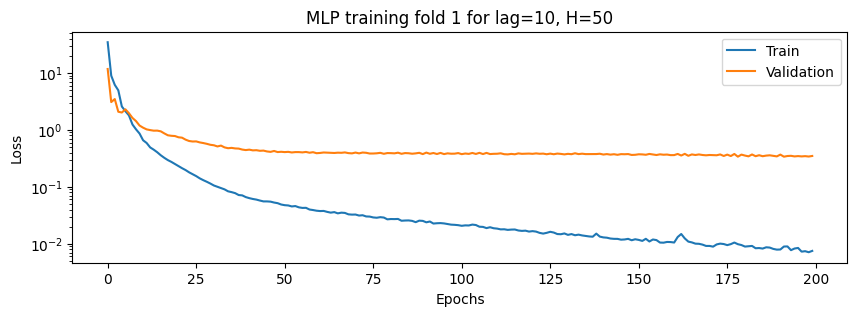

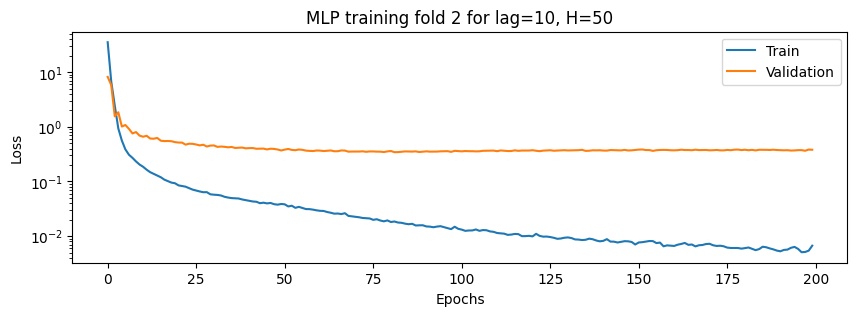

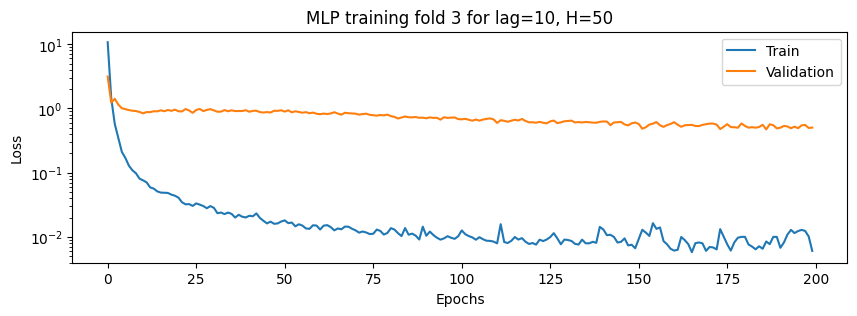

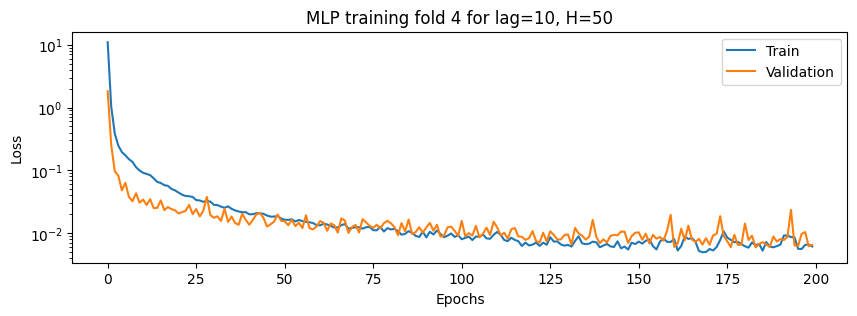

Testing lag=15, H=5
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE for lag=15, H=5: 0.157


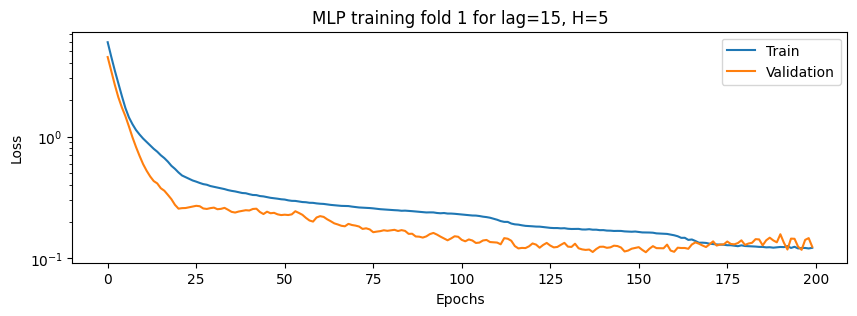

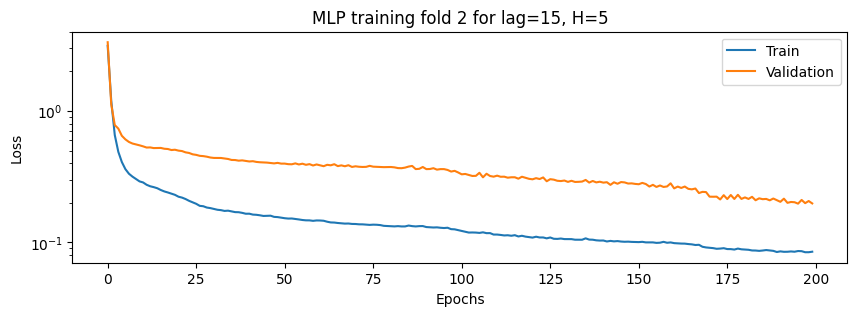

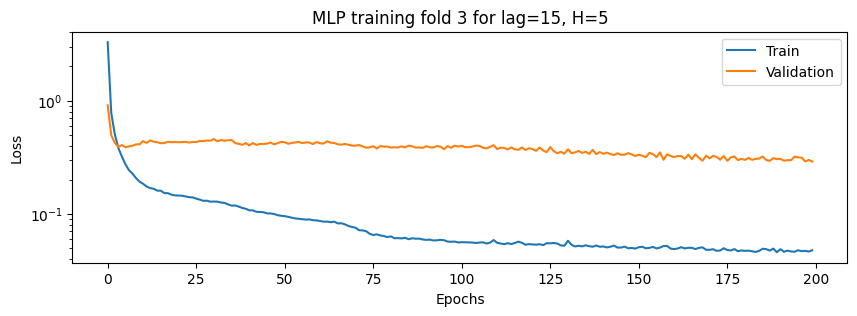

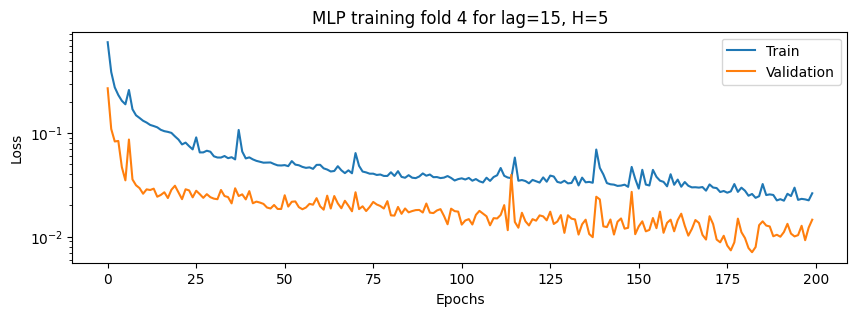

Testing lag=15, H=10
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE for lag=15, H=10: 0.207


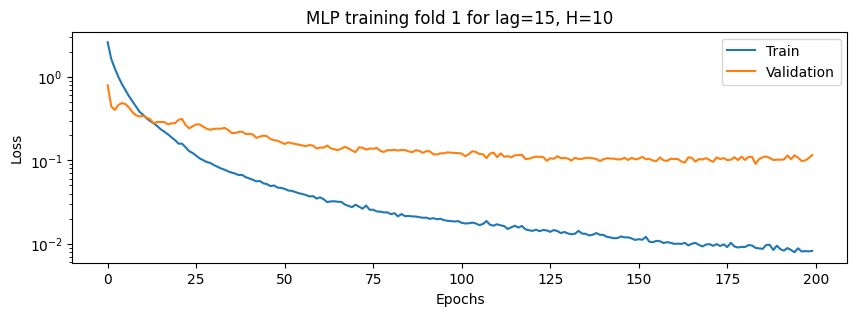

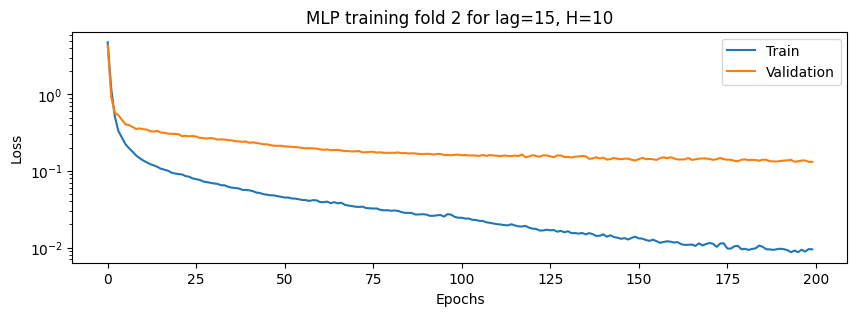

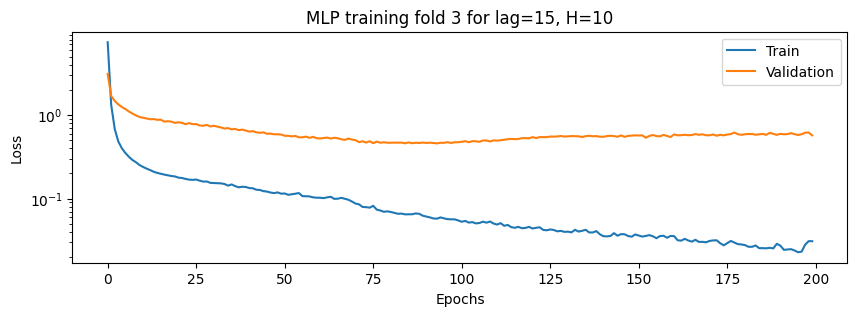

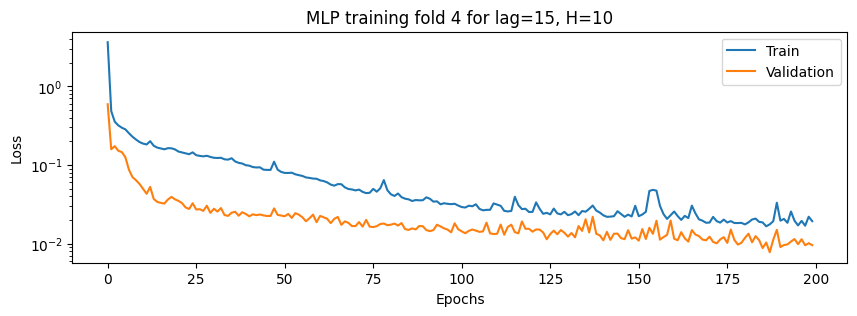

Testing lag=15, H=25
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE for lag=15, H=25: 0.202


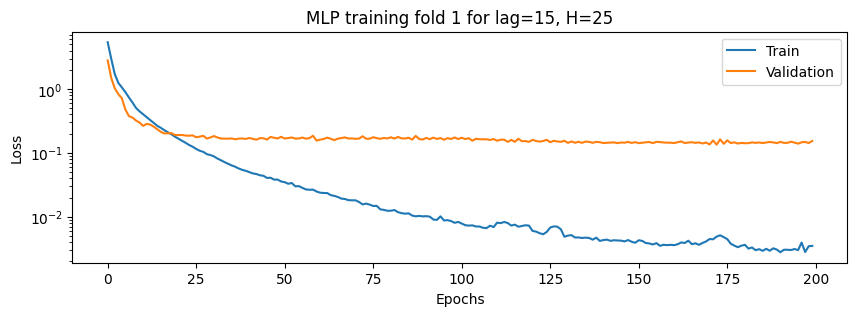

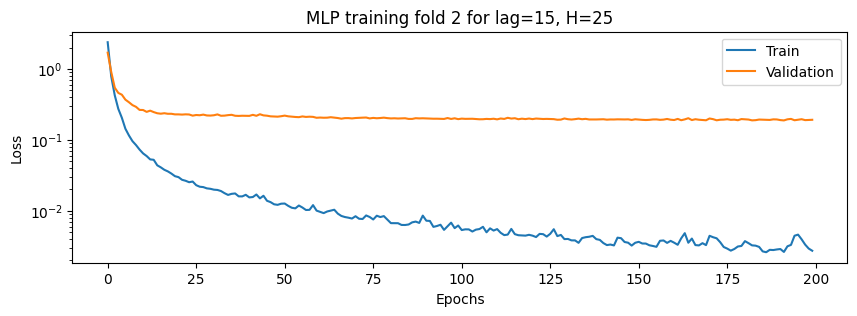

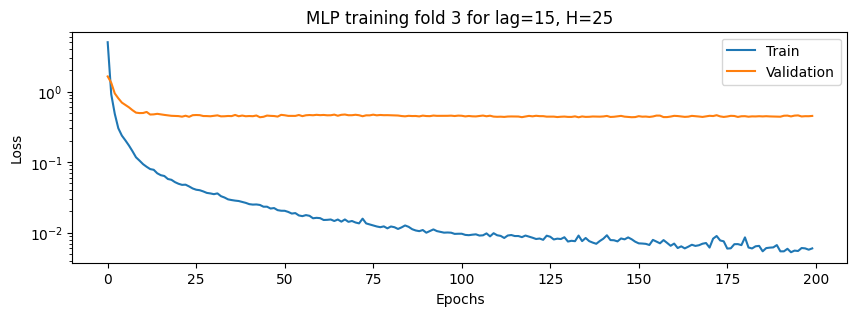

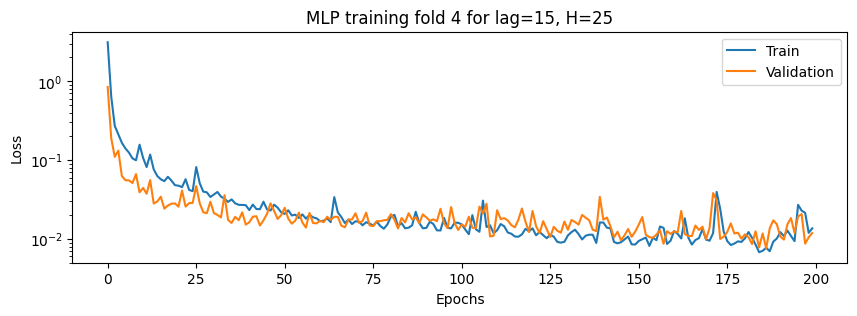

Testing lag=15, H=50
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE for lag=15, H=50: 0.610


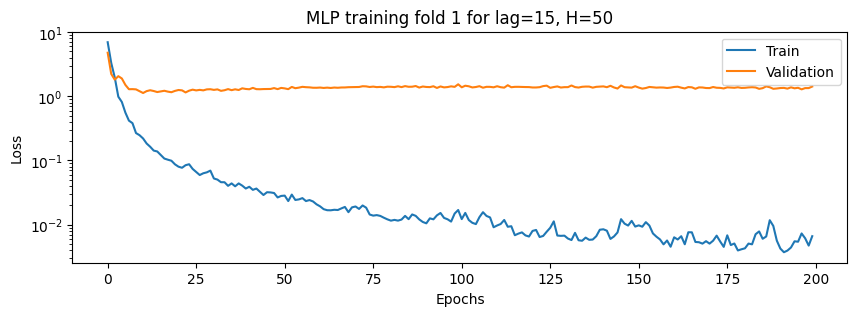

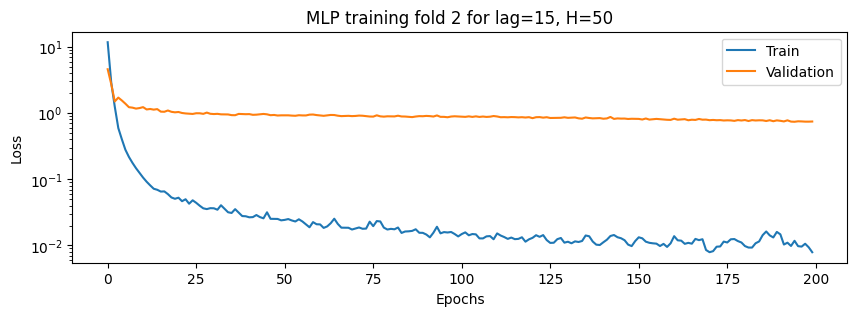

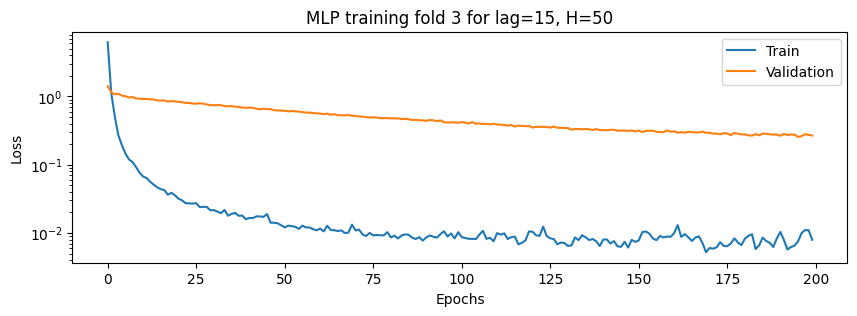

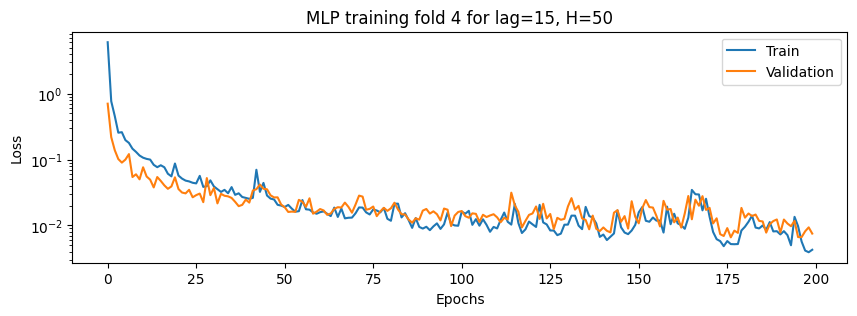

The best performance on the validation set is achieved with lag=5 and H=10: MSE = 0.042


In [ ]:
# Define ranges for the lags and hidden units (H) you want to investigate
lag_values = [1, 5, 10, 15]
H_values = [5, 10, 25, 50]

# Initialize a dictionary to keep track of the performance for each combination
performance = {}

# Outer loops to iterate over the different numbers of lags and hidden units
for lag in lag_values:
    for H in H_values:
        print(f"Testing lag={lag}, H={H}")
        validation_size = int(0.2*len(normalized))
        validation_folds = int(len(normalized)/(validation_size+lag))
        data, targets, folds = prepare_timeseries(normalized, lag, validation_size=validation_size, validation_folds=validation_folds)
        # Plot train and validation data for each fold:
        for f, fold in enumerate(folds):
          train_series = np.concatenate([data[fold.train_idxs[0]], targets[fold.train_idxs]])
          val_series = np.concatenate([data[fold.val_idxs[0]], targets[fold.val_idxs]])
        # Define and compile the MLP network architecture for the current combination
        net = MLP(lag, H, 1)
        net.compile(
            loss=keras.losses.MeanSquaredError(),
            optimizer=keras.optimizers.Adam(learning_rate=0.01)
        )

        # Initialize a list to keep track of the validation MSE for each fold
        fold_validation_mse = []
        # Initialize a list to keep track of the history for each fold
        histories = []

        # Loop over each fold and train the network
        for fold_number, fold in enumerate(folds):
            print(f"Training on fold {fold_number+1}/{len(folds)}...")

            # Reset the weights of the network for each fold
            net.set_weights([np.random.normal(size=w.shape) for w in net.get_weights()])

            # Fit the model to the current fold's training data
            history = net.fit(
                data[fold.train_idxs],
                targets[fold.train_idxs],
                validation_data=(data[fold.val_idxs], targets[fold.val_idxs]),
                epochs=200,
                verbose=0
            )

            # Store the validation MSE for this fold
            fold_validation_mse.append(history.history['val_loss'][-1])  # Assume the last value is the best for this fold

            # history
            histories.append(history)

        # Calculate the mean validation MSE across all folds for the current combination
        mean_validation_mse = np.mean(fold_validation_mse)
        performance[(lag, H)] = mean_validation_mse
        print(f"Mean Validation MSE for lag={lag}, H={H}: {mean_validation_mse:.3f}")
        # Now 'histories' contains the training history for each fold
        # After the cross-validation loop
        for idx, history in enumerate(histories):
            # Note the change here: 'history' instead of 'history.history'
            plot_history(history, f"MLP training fold {idx+1} for lag={lag}, H={H}")


# Find the best combination of lag and H based on validation MSE
best_lag, best_H = min(performance, key=performance.get)
best_mse = performance[(best_lag, best_H)]
print(f"The best performance on the validation set is achieved with lag={best_lag} and H={best_H}: MSE = {best_mse:.3f}")

# After finding the best lag and H, you could retrain the model using these parameters and evaluate it on the test set





### **Exercise 1**
Investigate the model performance with different lags and number of neurons. Discuss how the model looks and explain clearly how you tune the parameters and what the influence on the final prediction is. Which combination of parameters gives the best performance (MSE) on the test set?

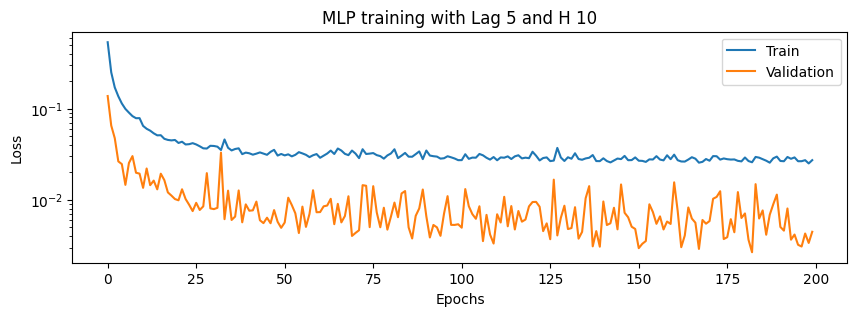

The MSE on the test set is: 2947.582


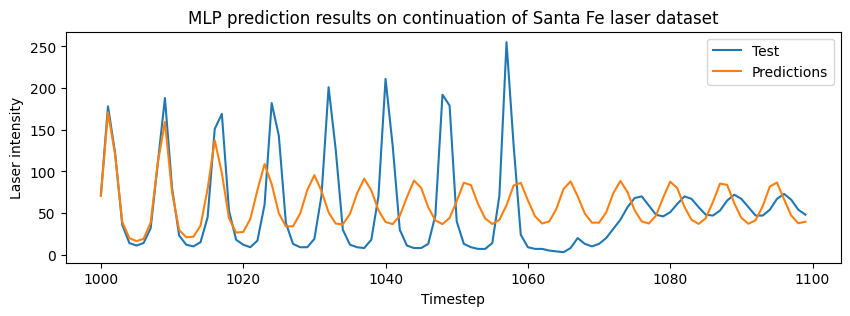

In [ ]:
net.reset_states()
best_lag = 5
best_H = 10

validation_size = int(0.2*len(normalized))
validation_folds = int(len(normalized)/(validation_size+best_lag))
data, targets, folds = prepare_timeseries(normalized, best_lag, validation_size, validation_folds)
# Plot train and validation data for each fold:
for f, fold in enumerate(folds):
  train_series = np.concatenate([data[fold.train_idxs[0]], targets[fold.train_idxs]])
  val_series = np.concatenate([data[fold.val_idxs[0]], targets[fold.val_idxs]])

net = MLP(best_lag, best_H, 1)
net.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=0.01)
)
fold = folds[-1]
history = net.fit(data[fold.train_idxs], targets[fold.train_idxs],
                  validation_data=(data[fold.val_idxs], targets[fold.val_idxs]),
                  epochs=200, verbose=0)
plot_history(history, f"MLP training with Lag {best_lag} and H {best_H}")

# Evaluation on test set
test_data = shift(data[-1], targets[-1])
predictions = np.empty(normalized_test.shape)
for t in range(len(predictions)):
  predictions[t] = net.predict(test_data.reshape((1, best_lag)), verbose=0).squeeze()
  test_data = shift(test_data, predictions[t])

# Rescale predictions
predictions_mlp = rescale(predictions, params)

# Compute the mean squared error between the predictions and test set
mse = np.mean((test_series - predictions_mlp)**2)
print("The MSE on the test set is: {:.3f}".format(mse))

# Plot
plot_timeseries({"Test": (1000, test_series), "Predictions": (1000, predictions_mlp)}, "MLP prediction results on continuation of Santa Fe laser dataset")

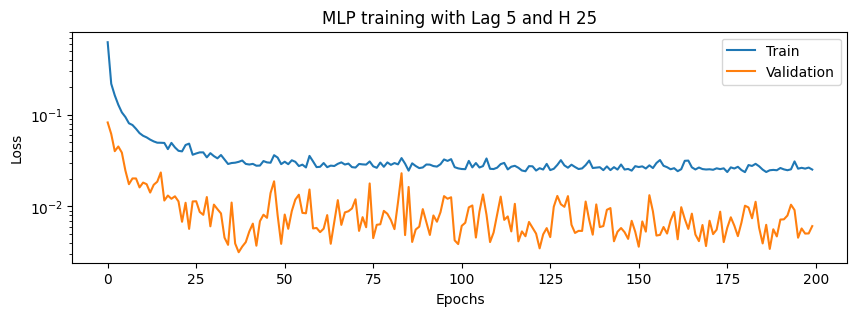

The MSE on the test set is: 5366.423


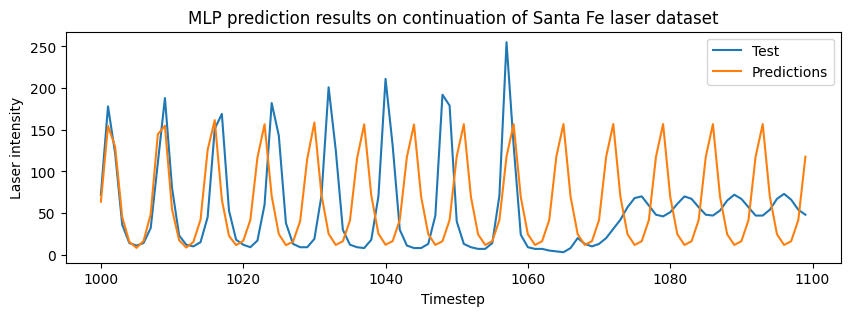

In [ ]:
net.reset_states()
best_lag = 5
best_H = 25

validation_size = int(0.2*len(normalized))
validation_folds = int(len(normalized)/(validation_size+best_lag))
data, targets, folds = prepare_timeseries(normalized, best_lag, validation_size, validation_folds)
# Plot train and validation data for each fold:
for f, fold in enumerate(folds):
  train_series = np.concatenate([data[fold.train_idxs[0]], targets[fold.train_idxs]])
  val_series = np.concatenate([data[fold.val_idxs[0]], targets[fold.val_idxs]])

net = MLP(best_lag, best_H, 1)
net.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=0.01)
)
fold = folds[-1]
history = net.fit(data[fold.train_idxs], targets[fold.train_idxs],
                  validation_data=(data[fold.val_idxs], targets[fold.val_idxs]),
                  epochs=200, verbose=0)
plot_history(history, f"MLP training with Lag {best_lag} and H {best_H}")

# Evaluation on test set
test_data = shift(data[-1], targets[-1])
predictions = np.empty(normalized_test.shape)
for t in range(len(predictions)):
  predictions[t] = net.predict(test_data.reshape((1, best_lag)), verbose=0).squeeze()
  test_data = shift(test_data, predictions[t])

# Rescale predictions
predictions_mlp = rescale(predictions, params)

# Compute the mean squared error between the predictions and test set
mse = np.mean((test_series - predictions_mlp)**2)
print("The MSE on the test set is: {:.3f}".format(mse))

# Plot
plot_timeseries({"Test": (1000, test_series), "Predictions": (1000, predictions_mlp)}, "MLP prediction results on continuation of Santa Fe laser dataset")

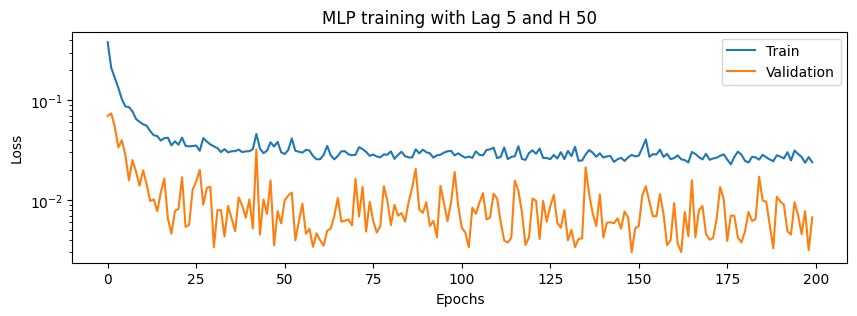

The MSE on the test set is: 6653.005


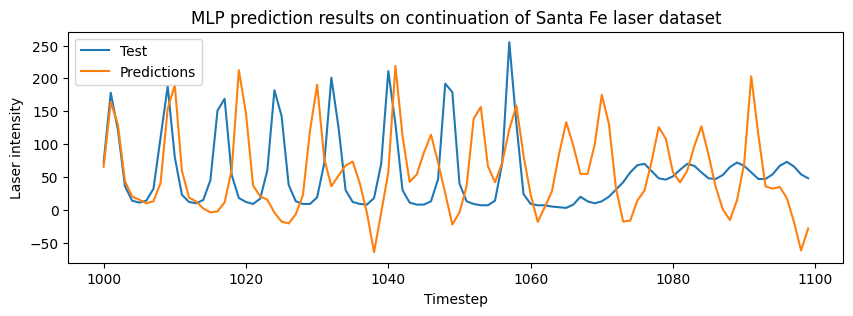

In [ ]:
net.reset_states()
best_lag = 5
best_H = 50

validation_size = int(0.2*len(normalized))
validation_folds = int(len(normalized)/(validation_size+best_lag))
data, targets, folds = prepare_timeseries(normalized, best_lag, validation_size, validation_folds)
# Plot train and validation data for each fold:
for f, fold in enumerate(folds):
  train_series = np.concatenate([data[fold.train_idxs[0]], targets[fold.train_idxs]])
  val_series = np.concatenate([data[fold.val_idxs[0]], targets[fold.val_idxs]])

net = MLP(best_lag, best_H, 1)
net.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=0.01)
)
fold = folds[-1]
history = net.fit(data[fold.train_idxs], targets[fold.train_idxs],
                  validation_data=(data[fold.val_idxs], targets[fold.val_idxs]),
                  epochs=200, verbose=0)
plot_history(history, f"MLP training with Lag {best_lag} and H {best_H}")

# Evaluation on test set
test_data = shift(data[-1], targets[-1])
predictions = np.empty(normalized_test.shape)
for t in range(len(predictions)):
  predictions[t] = net.predict(test_data.reshape((1, best_lag)), verbose=0).squeeze()
  test_data = shift(test_data, predictions[t])

# Rescale predictions
predictions_mlp = rescale(predictions, params)

# Compute the mean squared error between the predictions and test set
mse = np.mean((test_series - predictions_mlp)**2)
print("The MSE on the test set is: {:.3f}".format(mse))

# Plot
plot_timeseries({"Test": (1000, test_series), "Predictions": (1000, predictions_mlp)}, "MLP prediction results on continuation of Santa Fe laser dataset")

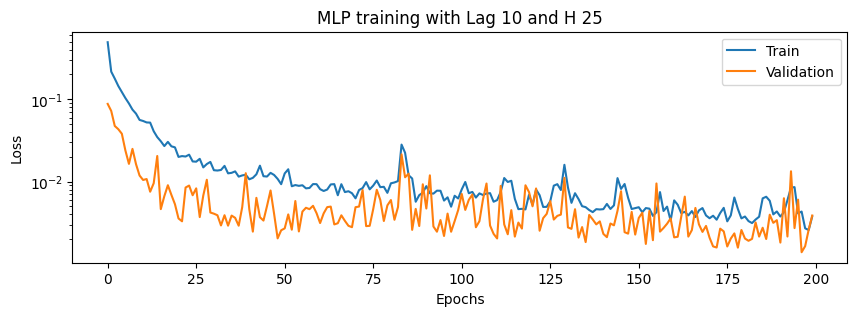

The MSE on the test set is: 5741.402


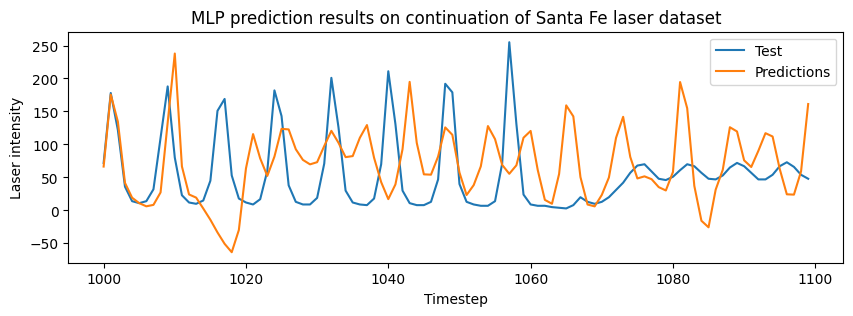

In [ ]:
net.reset_states()
best_lag = 10
best_H = 25

validation_size = int(0.2*len(normalized))
validation_folds = int(len(normalized)/(validation_size+best_lag))
data, targets, folds = prepare_timeseries(normalized, best_lag, validation_size, validation_folds)
# Plot train and validation data for each fold:
for f, fold in enumerate(folds):
  train_series = np.concatenate([data[fold.train_idxs[0]], targets[fold.train_idxs]])
  val_series = np.concatenate([data[fold.val_idxs[0]], targets[fold.val_idxs]])

net = MLP(best_lag, best_H, 1)
net.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=0.01)
)
fold = folds[-1]
history = net.fit(data[fold.train_idxs], targets[fold.train_idxs],
                  validation_data=(data[fold.val_idxs], targets[fold.val_idxs]),
                  epochs=200, verbose=0)
plot_history(history, f"MLP training with Lag {best_lag} and H {best_H}")

# Evaluation on test set
test_data = shift(data[-1], targets[-1])
predictions = np.empty(normalized_test.shape)
for t in range(len(predictions)):
  predictions[t] = net.predict(test_data.reshape((1, best_lag)), verbose=0).squeeze()
  test_data = shift(test_data, predictions[t])

# Rescale predictions
predictions_mlp = rescale(predictions, params)

# Compute the mean squared error between the predictions and test set
mse = np.mean((test_series - predictions_mlp)**2)
print("The MSE on the test set is: {:.3f}".format(mse))

# Plot
plot_timeseries({"Test": (1000, test_series), "Predictions": (1000, predictions_mlp)}, "MLP prediction results on continuation of Santa Fe laser dataset")

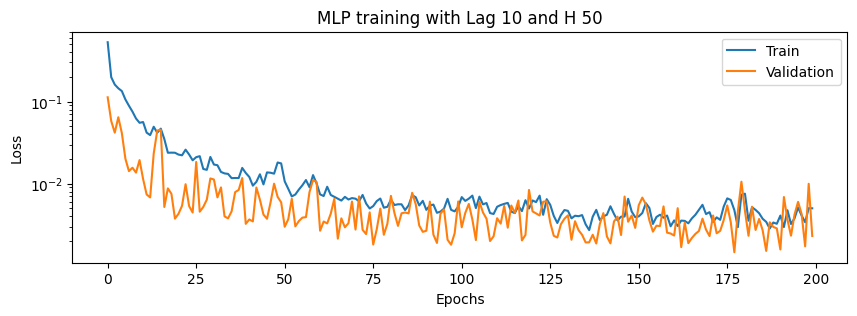

The MSE on the test set is: 4488.721


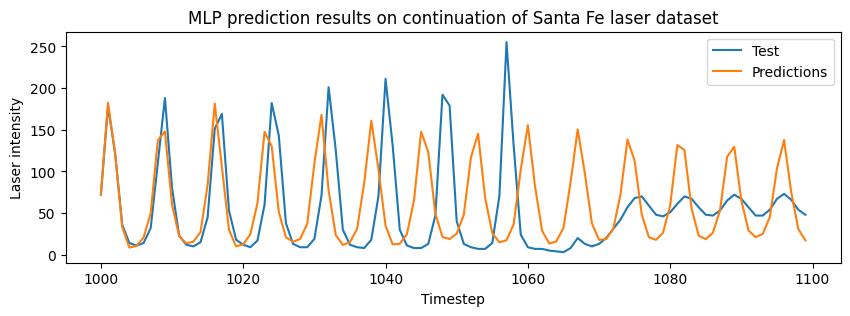

In [ ]:
net.reset_states()
best_lag = 10
best_H = 50

validation_size = int(0.2*len(normalized))
validation_folds = int(len(normalized)/(validation_size+best_lag))
data, targets, folds = prepare_timeseries(normalized, best_lag, validation_size, validation_folds)
# Plot train and validation data for each fold:
for f, fold in enumerate(folds):
  train_series = np.concatenate([data[fold.train_idxs[0]], targets[fold.train_idxs]])
  val_series = np.concatenate([data[fold.val_idxs[0]], targets[fold.val_idxs]])

net = MLP(best_lag, best_H, 1)
net.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=0.01)
)
fold = folds[-1]
history = net.fit(data[fold.train_idxs], targets[fold.train_idxs],
                  validation_data=(data[fold.val_idxs], targets[fold.val_idxs]),
                  epochs=200, verbose=0)
plot_history(history, f"MLP training with Lag {best_lag} and H {best_H}")

# Evaluation on test set
test_data = shift(data[-1], targets[-1])
predictions = np.empty(normalized_test.shape)
for t in range(len(predictions)):
  predictions[t] = net.predict(test_data.reshape((1, best_lag)), verbose=0).squeeze()
  test_data = shift(test_data, predictions[t])

# Rescale predictions
predictions_mlp = rescale(predictions, params)

# Compute the mean squared error between the predictions and test set
mse = np.mean((test_series - predictions_mlp)**2)
print("The MSE on the test set is: {:.3f}".format(mse))

# Plot
plot_timeseries({"Test": (1000, test_series), "Predictions": (1000, predictions_mlp)}, "MLP prediction results on continuation of Santa Fe laser dataset")

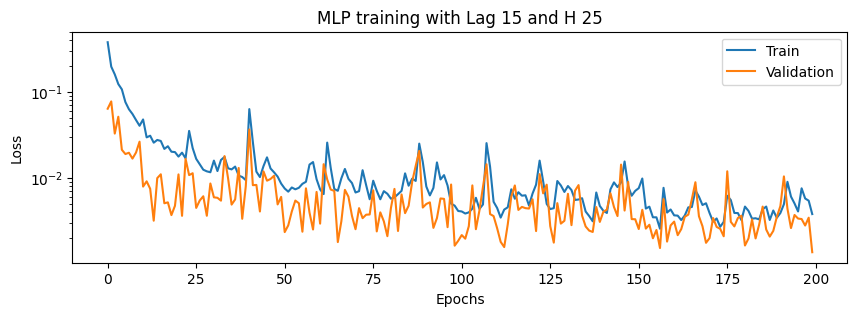

The MSE on the test set is: 3657.591


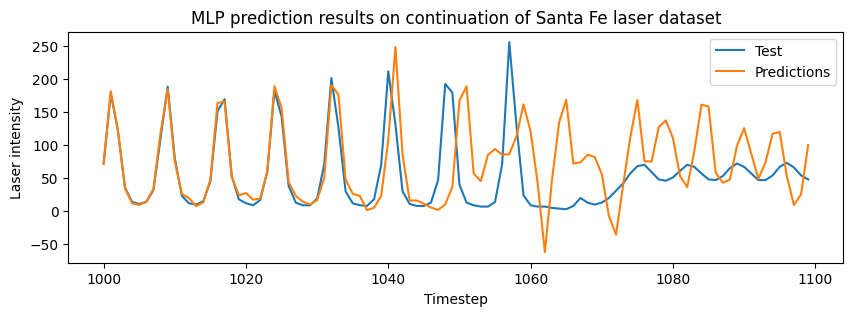

In [ ]:
net.reset_states()
best_lag = 15
best_H = 25

validation_size = int(0.2*len(normalized))
validation_folds = int(len(normalized)/(validation_size+best_lag))
data, targets, folds = prepare_timeseries(normalized, best_lag, validation_size, validation_folds)
# Plot train and validation data for each fold:
for f, fold in enumerate(folds):
  train_series = np.concatenate([data[fold.train_idxs[0]], targets[fold.train_idxs]])
  val_series = np.concatenate([data[fold.val_idxs[0]], targets[fold.val_idxs]])

net = MLP(best_lag, best_H, 1)
net.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=0.01)
)
fold = folds[-1]
history = net.fit(data[fold.train_idxs], targets[fold.train_idxs],
                  validation_data=(data[fold.val_idxs], targets[fold.val_idxs]),
                  epochs=200, verbose=0)
plot_history(history, f"MLP training with Lag {best_lag} and H {best_H}")

# Evaluation on test set
test_data = shift(data[-1], targets[-1])
predictions = np.empty(normalized_test.shape)
for t in range(len(predictions)):
  predictions[t] = net.predict(test_data.reshape((1, best_lag)), verbose=0).squeeze()
  test_data = shift(test_data, predictions[t])

# Rescale predictions
predictions_mlp = rescale(predictions, params)

# Compute the mean squared error between the predictions and test set
mse = np.mean((test_series - predictions_mlp)**2)
print("The MSE on the test set is: {:.3f}".format(mse))

# Plot
plot_timeseries({"Test": (1000, test_series), "Predictions": (1000, predictions_mlp)}, "MLP prediction results on continuation of Santa Fe laser dataset")

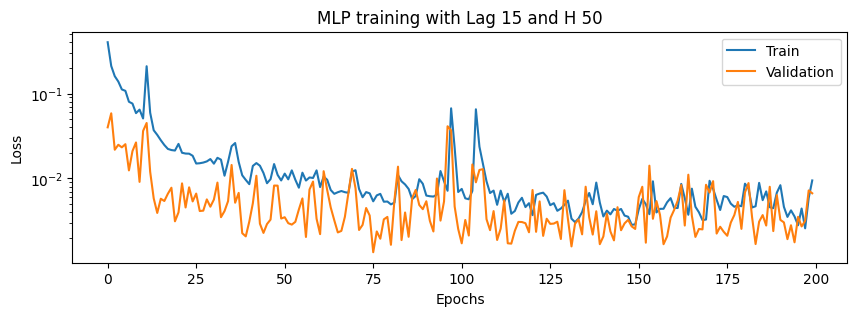

The MSE on the test set is: 7951.678


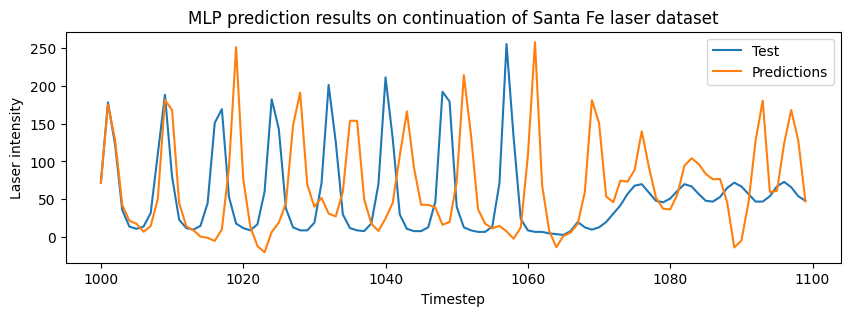

In [ ]:
net.reset_states()
best_lag = 15
best_H = 50

validation_size = int(0.2*len(normalized))
validation_folds = int(len(normalized)/(validation_size+best_lag))
data, targets, folds = prepare_timeseries(normalized, best_lag, validation_size, validation_folds)
# Plot train and validation data for each fold:
for f, fold in enumerate(folds):
  train_series = np.concatenate([data[fold.train_idxs[0]], targets[fold.train_idxs]])
  val_series = np.concatenate([data[fold.val_idxs[0]], targets[fold.val_idxs]])

net = MLP(best_lag, best_H, 1)
net.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=0.01)
)
fold = folds[-1]
history = net.fit(data[fold.train_idxs], targets[fold.train_idxs],
                  validation_data=(data[fold.val_idxs], targets[fold.val_idxs]),
                  epochs=200, verbose=0)
plot_history(history, f"MLP training with Lag {best_lag} and H {best_H}")

# Evaluation on test set
test_data = shift(data[-1], targets[-1])
predictions = np.empty(normalized_test.shape)
for t in range(len(predictions)):
  predictions[t] = net.predict(test_data.reshape((1, best_lag)), verbose=0).squeeze()
  test_data = shift(test_data, predictions[t])

# Rescale predictions
predictions_mlp = rescale(predictions, params)

# Compute the mean squared error between the predictions and test set
mse = np.mean((test_series - predictions_mlp)**2)
print("The MSE on the test set is: {:.3f}".format(mse))

# Plot
plot_timeseries({"Test": (1000, test_series), "Predictions": (1000, predictions_mlp)}, "MLP prediction results on continuation of Santa Fe laser dataset")

## LSTM
We now train the second model, which is a Long Short Term Memory (LSTM) network. These are a special kind of RNN, capable of learning long-term dependencies. LSTMs contain information outside the normal flow of the recurrent network in a gated cell. Information can be stored in, written to, or read from a cell, much like data in a computer's memory. The cell makes decisions about what to store and when to allow reads, writes and erasures, via gates that open and close. Those gates act on the signals they receive, and similar to the neural network's nodes, they block or pass on information based on its strength and importance, which they filter with their own sets of weights. Those weights, like the weights that modulate input and hidden states, are adjusted via the recurrent network's learning process. That is, the cells learn when to allow data to enter, leave or be deleted through the iterative process of making guesses, backpropagating the error, and adjusting weights via gradient descent.

In [ ]:
# Define the LSTM network structure
def LSTM(input_dim, hidden_dim, output_dim):
  return keras.Sequential([
    keras.layers.Input(shape=[None, input_dim], batch_size=1),  # LSTM layer expects input of shape (B, T, F) with B batch size, T timesteps, F feature size
    keras.layers.LSTM(units=hidden_dim, return_sequences=True, stateful=True),  # Output of shape (B, T, H) with H hidden state size
    keras.layers.Dense(units=output_dim)  # Output of shape (B, T, O) with O output size
  ])

class LSTMCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    self.model.reset_states()  # Make sure the LSTM's hidden state is reset after every epoch

Train the LSTM on the last training fold. You can later put this code in a `for` loop to train on each of the training folds for determining the optimal hyperparameters using $N$-fold cross-validation.

In [ ]:
net = LSTM(lag, H, 1)
net.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=0.001)
)
fold = folds[-1]
history = net.fit(
    data[fold.train_idxs].reshape((1, -1, lag)), targets[fold.train_idxs].reshape((1, -1)),
    validation_data=(data[fold.val_idxs].reshape((1, -1, lag)), targets[fold.val_idxs].reshape((1, -1))),
    epochs=150, callbacks=[LSTMCallback()], verbose=0)

Plot the train and validation loss curves.

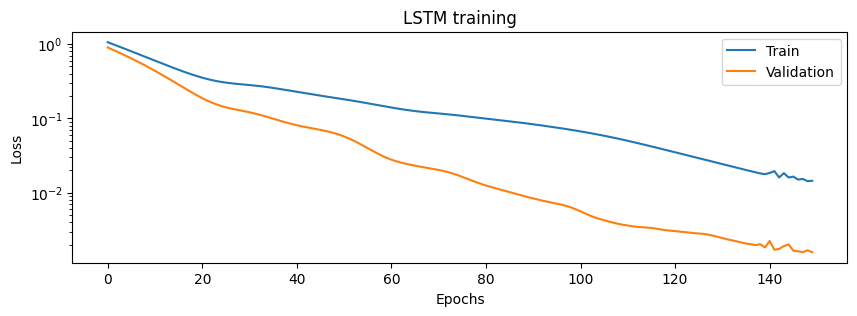

In [ ]:
plot_history(history, "LSTM training")

### **For Loop**
Investigate the model performance with different lags and number of hidden states. Discuss how the model looks and explain clearly how you tune the parameters and what the influence on the final prediction is. Which combination of parameters gives the best performance (MSE) on the test set?

In [ ]:
# Define ranges for lags, hidden units (H), and the number of folds for cross-validation
lag_values = [1, 5, 10, 15]
H_values = [5, 10, 25, 50]

# Initialize a dictionary to keep track of the performance for each combination
performance = {}

# Start the grid search
for lag in lag_values:
    for H in H_values:
      print(f"Testing lag={lag}, H={H}")
      # Prepare the data with the current lag, this function needs to be defined correctly
      validation_size = int(0.2*len(normalized))
      validation_folds = int(len(normalized)/(validation_size+lag))

      data, targets, folds = prepare_timeseries(normalized, lag, validation_size=validation_size, validation_folds=validation_folds)
      # Plot train and validation data for each fold:
      for f, fold in enumerate(folds):
        train_series = np.concatenate([data[fold.train_idxs[0]], targets[fold.train_idxs]])
        val_series = np.concatenate([data[fold.val_idxs[0]], targets[fold.val_idxs]])

      # Initialize a list to keep track of the validation MSE for each fold
      fold_validation_mse = []

      # Loop over each fold for cross-validation
      for fold_number, fold in enumerate(folds):
        print(f"Training on fold {fold_number+1}/{len(folds)}...")

        # Create a new instance of the LSTM model for the current fold
        net = LSTM(lag, H, 1)
        net.compile(
            loss=keras.losses.MeanSquaredError(),
            optimizer=keras.optimizers.Adam(learning_rate=0.001)
            )

        # Fit the model to the current fold's training data
        history = net.fit(
            data[fold.train_idxs].reshape((1, -1, lag)), targets[fold.train_idxs].reshape((1, -1)),
            validation_data=(
                data[fold.val_idxs].reshape((1, -1, lag)), targets[fold.val_idxs].reshape((1, -1))
                ),
            epochs=150, callbacks=[LSTMCallback()], verbose=0
            )

        # Store the validation MSE for this fold
        fold_validation_mse.append(history.history['val_loss'][-1])

        # Reset the LSTM state for the next fold
        net.reset_states()

      # Calculate the mean validation MSE across all folds for the current combination
      mean_validation_mse = np.mean(fold_validation_mse)
      performance[(lag, H)] = mean_validation_mse
      print(f"Mean Validation MSE: {mean_validation_mse:.3f} for lag={lag}, H={H}")

# Find the best combination based on validation MSE
best_parameters = min(performance, key=performance.get)
best_mse = performance[best_parameters]
print(f"The best performance on the validation set is achieved with lag={best_parameters[0]}, H={best_parameters[1]}: MSE = {best_mse:.3f}")

# After finding the best hyperparameters, you should retrain the model on the full training set using these parameters and then evaluate it on the test set.
# The plotting code would remain the same, provided that you pass the correct predictions from the best model.


Testing lag=1, H=5
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE: 0.637 for lag=1, H=5
Testing lag=1, H=10
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE: 0.340 for lag=1, H=10
Testing lag=1, H=25
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE: 0.206 for lag=1, H=25
Testing lag=1, H=50
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE: 0.170 for lag=1, H=50
Testing lag=5, H=5
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE: 0.443 for lag=5, H=5
Testing lag=5, H=10
Training on fold 1/4...
Training on fold 2/4...
Training on fold 3/4...
Training on fold 4/4...
Mean Validation MSE: 0.226 for lag=5, H=10
Testing lag=5, H=25
Training on fold 1/4...
Traini

### **Exercise 2**
Investigate the model performance with different lags and number of hidden states. Discuss how the model looks and explain clearly how you tune the parameters and what the influence on the final prediction is. Which combination of parameters gives the best performance (MSE) on the test set?

Compare the results of the recurrent MLP with the LSTM. Which model do you prefer and why?

The MSE on the test set is: 3872.362


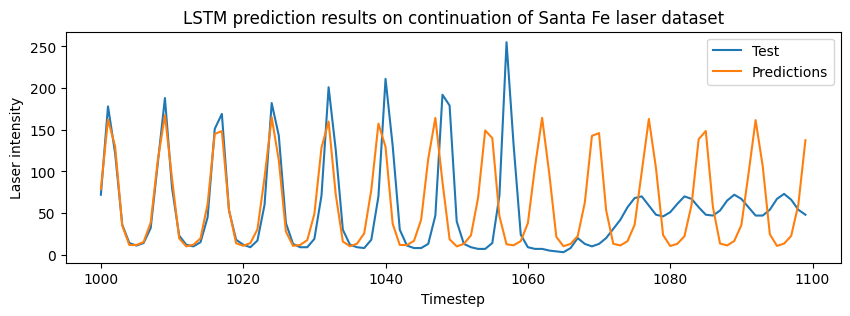

In [ ]:
best_lstm_lag, best_lstm_H = best_parameters[0], best_parameters[1]
# Prepare the data with the current lag, this function needs to be defined correctly
validation_size = int(0.2*len(normalized))
validation_folds = int(len(normalized)/(validation_size+best_lstm_lag))

data, targets, folds = prepare_timeseries(normalized, best_lstm_lag, validation_size=validation_size, validation_folds=validation_folds)
# Plot train and validation data for each fold:
for f, fold in enumerate(folds):
  train_series = np.concatenate([data[fold.train_idxs[0]], targets[fold.train_idxs]])
  val_series = np.concatenate([data[fold.val_idxs[0]], targets[fold.val_idxs]])

# Create a new instance of the LSTM model for the current fold
net = LSTM(best_lstm_lag, best_lstm_H, 1)
net.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001)
    )

# Fit the model to the current fold's training data
history = net.fit(
    data[fold.train_idxs].reshape((1, -1, best_lstm_lag)), targets[fold.train_idxs].reshape((1, -1)),
    validation_data=(
        data[fold.val_idxs].reshape((1, -1, best_lstm_lag)), targets[fold.val_idxs].reshape((1, -1))
        ),
    epochs=150, callbacks=[LSTMCallback()], verbose=0
    )

# Store the validation MSE for this fold
fold_validation_mse.append(history.history['val_loss'][-1])

# LSTM Evaluation
net.reset_states()
net.predict(data.reshape(1, -1, best_lstm_lag), verbose=0)
test_data = shift(data[-1], targets[-1])
predictions = np.empty(normalized_test.shape)

for t in range(len(predictions)):
  predictions[t] = net.predict(test_data.reshape((1, 1, best_lstm_lag)), verbose=0).squeeze()
  test_data = shift(test_data, predictions[t])

# Rescale predictions
predictions_lstm = rescale(predictions, params)

# Compute the mean squared error between the predictions and test set
mse = np.mean((test_series - predictions_lstm)**2)
print("The MSE on the test set is: {:.3f}".format(mse))

# Plot
plot_timeseries({"Test": (1000, test_series), "Predictions": (1000, predictions_lstm)}, "LSTM prediction results on continuation of Santa Fe laser dataset")

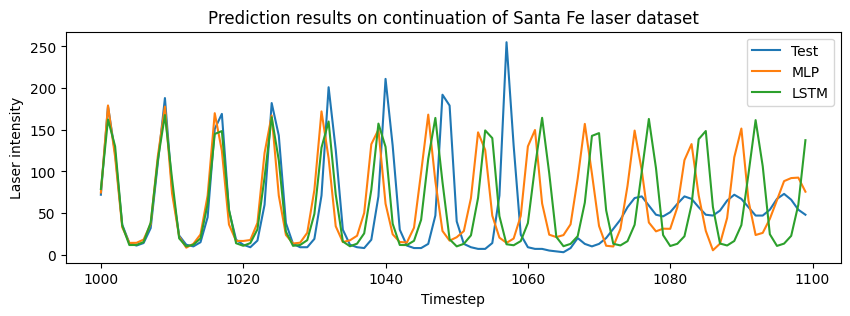

In [ ]:
# Comparison of both models
plot_timeseries({"Test": (1000, test_series), "MLP": (1000, predictions_mlp), "LSTM": (1000, predictions_lstm)}, "Prediction results on continuation of Santa Fe laser dataset")